# Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, precision_score, f1_score, recall_score

#xgboost
import xgboost

#lightgbm
import lightgbm

# Custom functions

In [2]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores




def train_models(models, x_data, y_data, train_size, save=False, preprocessor=None):
    
    if type(x_data) == pd.core.frame.DataFrame or type(x_data) == pd.core.series.Series:
        x_data = x_data.to_numpy()
    
    if type(y_data) == pd.core.frame.DataFrame or type(y_data) == pd.core.series.Series:
        y_data = y_data.to_numpy(dtype=np.float64)
    
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size = train_size, shuffle=True)
    
    trained_models = []
    cms = []
    
    accuracies = []
    maes = []
    precisions = []
    recalls = []
    f1s = []
    
    
    for key in models:
        print(f'using model: {key}')
        start = time.time()
        
        if preprocessor==None:
            pipe = Pipeline([
                (key, models[key])
            ])
            
        else:
            pipe = Pipeline([
                    ('Preprocessor', preprocessor),
                    (key, models[key])
                    ])
        
        pipe.fit(x_train, y_train)
        preds = pipe.predict(x_test)
        accuracy = pipe.score(x_test, y_test)
        mae = mean_absolute_error(y_test, preds)
        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        
        
        if save:
            joblib.dump(pipe, key+'.pkl')
        trained_models.append(pipe)
        cms.append(confusion_matrix(y_test, preds))
        
        accuracies.append(accuracy)
        maes.append(mae)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        
        end = time.time()
        print(f'Accuracy: {accuracy:.4f} ; MAE: {mae:.4f} ; Precision: {precision:.4f} ; Recall: {recall:.4f} ; F1: {f1:.4f} \t finished in {(end-start):.4f} second(s)\n')
        
    return trained_models, cms, [accuracies, maes, precisions, recalls, f1s]

# List of models to use

In [3]:
models = {
    'Logistic Regression' : linear_model.LogisticRegression(),
    'Ridge Classifier' : linear_model.RidgeClassifier(),
    'SGD classifier' : linear_model.SGDClassifier(),
    'Passive Aggressive Classifier' : linear_model.PassiveAggressiveClassifier(),
    'Linear Discriminant Analysis' : LinearDiscriminantAnalysis(store_covariance=True),
    'Quadratic Discriminant Analysis' : QuadraticDiscriminantAnalysis(store_covariance=True),
    'Suport Vector Classifier' : svm.SVC(),
    'Linear Support Vector Classifier' : svm.LinearSVC(),
    'KNeighbors Classifier' : neighbors.KNeighborsClassifier(n_neighbors=11),
    'Gaussian Naive Bayes' : naive_bayes.GaussianNB(),
    'Decision Tree Classifier' : tree.DecisionTreeClassifier(),
    'Hist Gradient Boosting Classifier' : ensemble.HistGradientBoostingClassifier(),
    'Gradient Boosting Classifier' : ensemble.GradientBoostingClassifier(),
    'Random Forest Classifier' : ensemble.RandomForestClassifier(n_estimators=200),
    'Bagging Classifier' : ensemble.BaggingClassifier(neighbors.KNeighborsClassifier(), max_samples=0.5, max_features=0.5),
    'Voting Classifier' : ensemble.VotingClassifier(estimators=[('lr', linear_model.LogisticRegression()),
                                               ('rf', ensemble.RandomForestClassifier(n_estimators=200)),
                                               ('gnb', naive_bayes.GaussianNB())], 
                                               voting='hard'),
    'AdaBoost Classifier' : ensemble.AdaBoostClassifier(n_estimators=200),
    'XGBoost Classifier' : xgboost.XGBClassifier(n_estimators = 1000, max_depth = 200, learning_rate=1.0, objective='binary:logistic'),
    'LightGBM Classifier' : lightgbm.LGBMClassifier(n_estimators=1000)
    
    }

# Importing Data

In [4]:
data_csv = pd.read_csv('/kaggle/input/smart-grid-stability/smart_grid_stability_augmented.csv')
classes = {0: 'unstable', 1: 'stable'}
print(f'number of entries in the dataset: {len(data_csv)}')

number of entries in the dataset: 60000


# Replacing labels with numbers

In [5]:
new_csv = data_csv.copy()
new_csv.loc[new_csv['stabf'] == 'unstable', 'stabf'] = 0
new_csv.loc[new_csv['stabf'] == 'stable', 'stabf'] = 1

# Data preparation for training

In [6]:
x_data = new_csv.drop(['stab','stabf'], axis=1)
standard_x = preprocessing.StandardScaler().fit_transform(x_data)
standard_x = pd.DataFrame(standard_x, columns=x_data.columns)
y_data = new_csv['stabf']

# Training without feature engineering

In [7]:
model_scores_dict = {}

In [8]:
score_names = ['Accuracy', 'MAE', 'Precision', 'Recall', 'F1']

In [9]:
def make_scores_table(scores):
    scores_dict = {}
    for i in range(len(scores)):
        scores_dict[score_names[i]] = scores[i]
    return pd.DataFrame(scores_dict, index=list(models.keys()))

In [10]:
preprocessor = preprocessing.StandardScaler()
trained_models, cms, scores = train_models(models, x_data, y_data, train_size=0.9, save=False, preprocessor=preprocessor)
model_scores_dict['Standard Training'] = [f'{s*100:.2f}%' for s in scores[0]]
standard_training_table = make_scores_table(scores)
standard_training_table.to_csv('standard training.csv')

using model: Logistic Regression
Accuracy: 0.8218 ; MAE: 0.1782 ; Precision: 0.7763 ; Recall: 0.7090 ; F1: 0.7411 	 finished in 0.1396 second(s)

using model: Ridge Classifier
Accuracy: 0.8200 ; MAE: 0.1800 ; Precision: 0.7761 ; Recall: 0.7020 ; F1: 0.7372 	 finished in 0.1453 second(s)

using model: SGD classifier
Accuracy: 0.8192 ; MAE: 0.1808 ; Precision: 0.7593 ; Recall: 0.7280 ; F1: 0.7433 	 finished in 0.2537 second(s)

using model: Passive Aggressive Classifier
Accuracy: 0.7943 ; MAE: 0.2057 ; Precision: 0.8412 ; Recall: 0.5278 ; F1: 0.6486 	 finished in 0.1611 second(s)

using model: Linear Discriminant Analysis
Accuracy: 0.8215 ; MAE: 0.1785 ; Precision: 0.7749 ; Recall: 0.7099 ; F1: 0.7410 	 finished in 0.2288 second(s)

using model: Quadratic Discriminant Analysis
Accuracy: 0.8762 ; MAE: 0.1238 ; Precision: 0.8436 ; Recall: 0.8049 ; F1: 0.8238 	 finished in 0.1898 second(s)

using model: Suport Vector Classifier


/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.9813 ; MAE: 0.0187 ; Precision: 0.9789 ; Recall: 0.9690 ; F1: 0.9739 	 finished in 31.9006 second(s)

using model: Linear Support Vector Classifier
Accuracy: 0.8215 ; MAE: 0.1785 ; Precision: 0.7757 ; Recall: 0.7085 ; F1: 0.7406 	 finished in 3.1283 second(s)

using model: KNeighbors Classifier
Accuracy: 0.9020 ; MAE: 0.0980 ; Precision: 0.9153 ; Recall: 0.8017 ; F1: 0.8547 	 finished in 7.3752 second(s)

using model: Gaussian Naive Bayes
Accuracy: 0.8360 ; MAE: 0.1640 ; Precision: 0.8393 ; Recall: 0.6728 ; F1: 0.7469 	 finished in 0.0578 second(s)

using model: Decision Tree Classifier
Accuracy: 0.8935 ; MAE: 0.1065 ; Precision: 0.8534 ; Recall: 0.8499 ; F1: 0.8516 	 finished in 1.0298 second(s)

using model: Hist Gradient Boosting Classifier
Accuracy: 0.9630 ; MAE: 0.0370 ; Precision: 0.9575 ; Recall: 0.9388 ; F1: 0.9481 	 finished in 1.7685 second(s)

using model: Gradient Boosting Classifier
Accuracy: 0.9310 ; MAE: 0.0690 ; Precision: 0.9391 ; Recall: 0.8642 ; F1: 0.900

In [11]:
standard_training_table

Accuracy       MAE  Precision    Recall  \
Logistic Regression                0.821833  0.178167   0.776256  0.708990   
Ridge Classifier                   0.820000  0.180000   0.776127  0.702039   
SGD classifier                     0.819167  0.180833   0.759304  0.727989   
Passive Aggressive Classifier      0.794333  0.205667   0.841211  0.527804   
Linear Discriminant Analysis       0.821500  0.178500   0.774911  0.709917   
Quadratic Discriminant Analysis    0.876167  0.123833   0.843613  0.804912   
Suport Vector Classifier           0.981333  0.018667   0.978933  0.968953   
Linear Support Vector Classifier   0.821500  0.178500   0.775748  0.708526   
KNeighbors Classifier              0.902000  0.098000   0.915344  0.801668   
Gaussian Naive Bayes               0.836000  0.164000   0.839306  0.672845   
Decision Tree Classifier           0.893500  0.106500   0.853420  0.849861   
Hist Gradient Boosting Classifier  0.963000  0.037000   0.957467  0.938832   
Gradient Boosting Classifier       0.931000  0.069000   0.939074  0.864226   
Random Forest Classifier           0.949833  0.050167   0.948768  0.909639   
Bagging Classifier                 0.825333  0.174667   0.900433  0.578313   
Voting Classifier                  0.850167  0.149833   0.846069  0.713160   
AdaBoost Classifier                0.863833  0.136167   0.832095  0.778499   
XGBoost Classifier                 0.984500  0.015500   0.983607  0.973123   
LightGBM Classifier                0.997000  0.003000   0.997212  0.994439   

                                         F1  
Logistic Regression                0.741100  
Ridge Classifier                   0.737226  
SGD classifier                     0.743317  
Passive Aggressive Classifier      0.648633  
Linear Discriminant Analysis       0.740992  
Quadratic Discriminant Analysis    0.823808  
Suport Vector Classifier           0.973917  
Linear Support Vector Classifier   0.740615  
KNeighbors Classifier              0.854743  
Gaussian Naive Bayes               0.746914  
Decision Tree Classifier           0.851637  
Hist Gradient Boosting Classifier  0.948058  
Gradient Boosting Classifier       0.900097  
Random Forest Classifier           0.928791  
Bagging Classifier                 0.704289  
Voting Classifier                  0.773950  
AdaBoost Classifier                0.804405  
XGBoost Classifier                 0.978337  
LightGBM Classifier                0.995824

# Display confusion matrices

<Figure size 640x480 with 0 Axes>

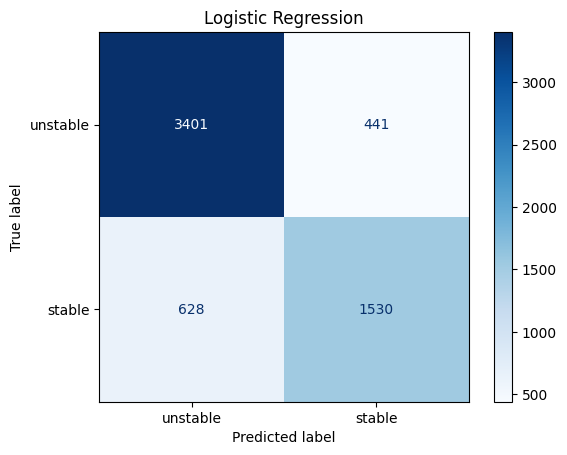

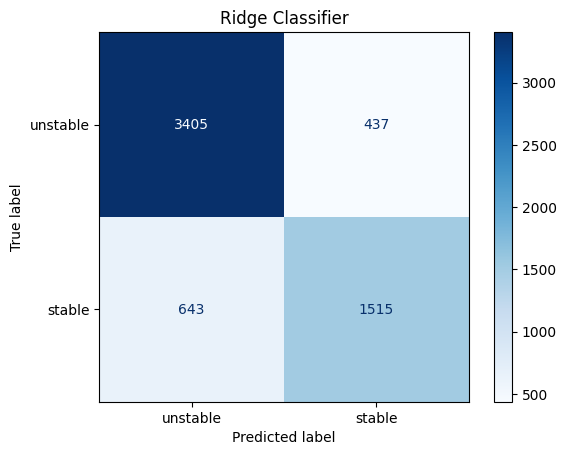

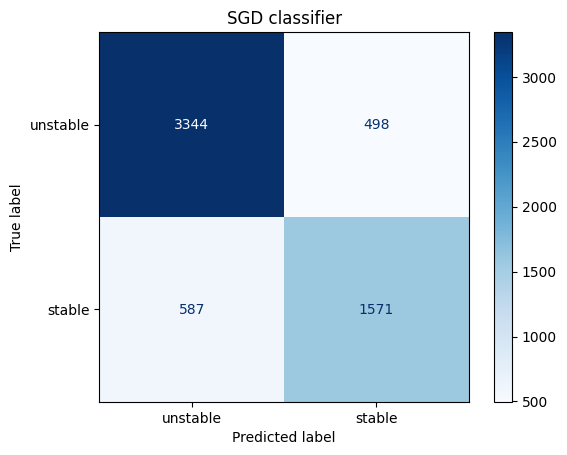

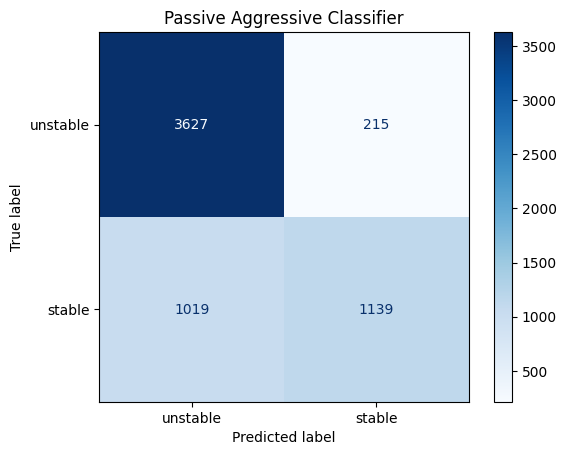

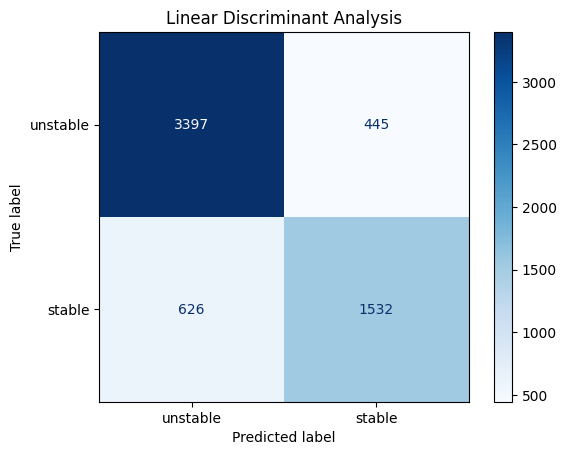

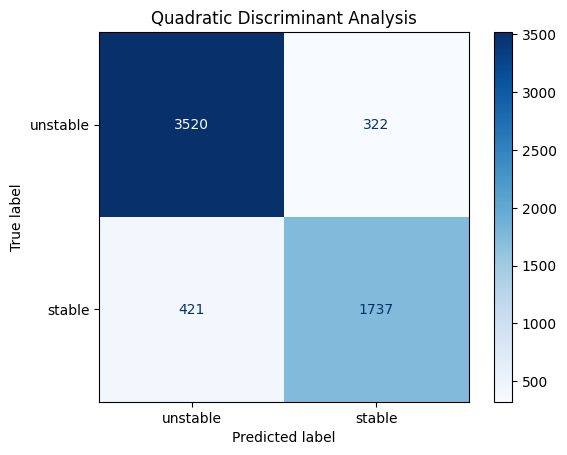

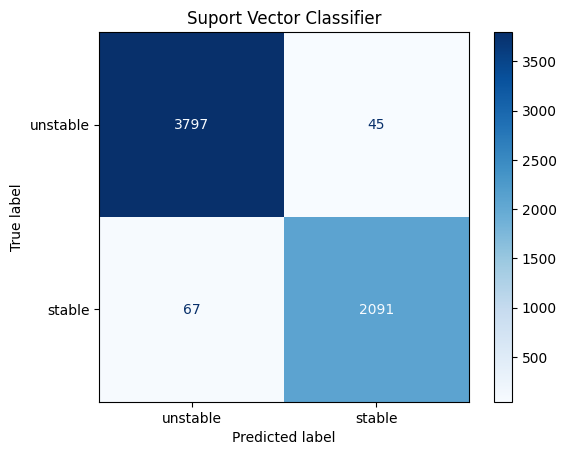

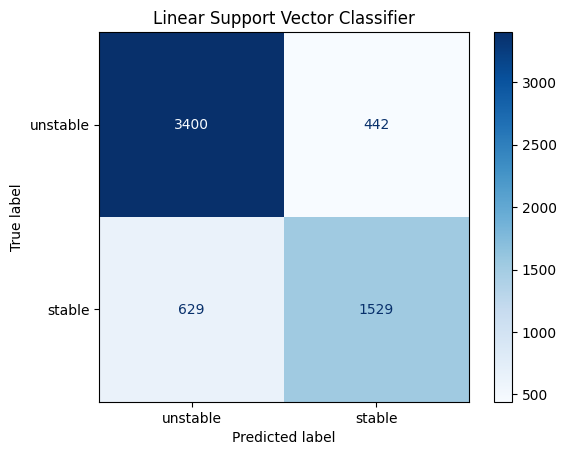

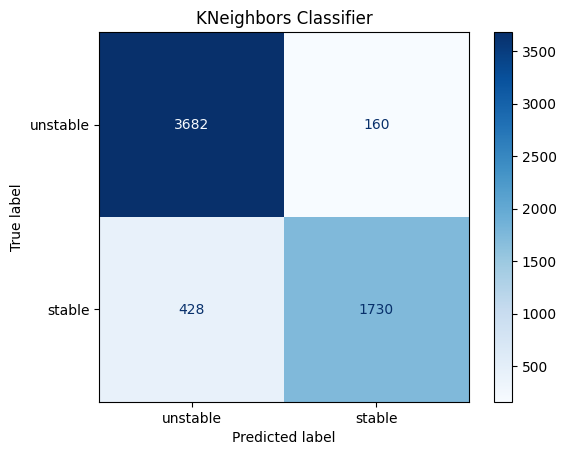

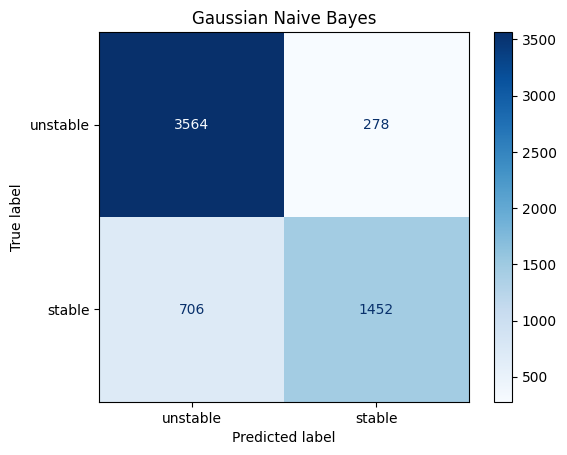

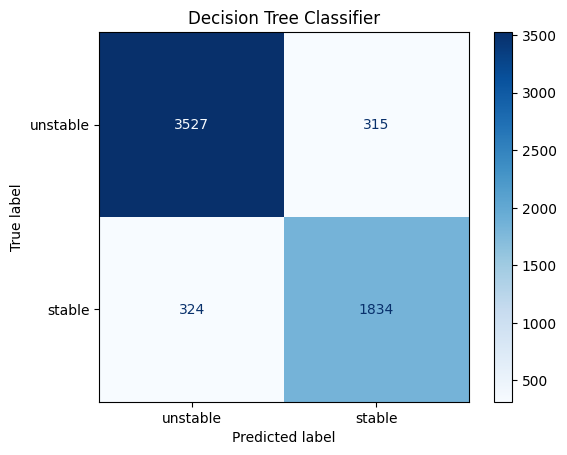

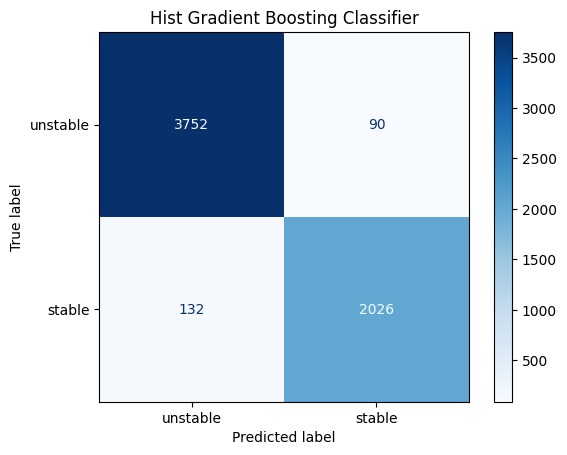

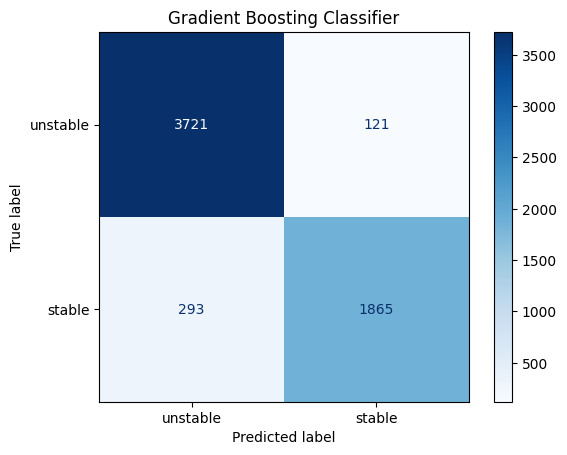

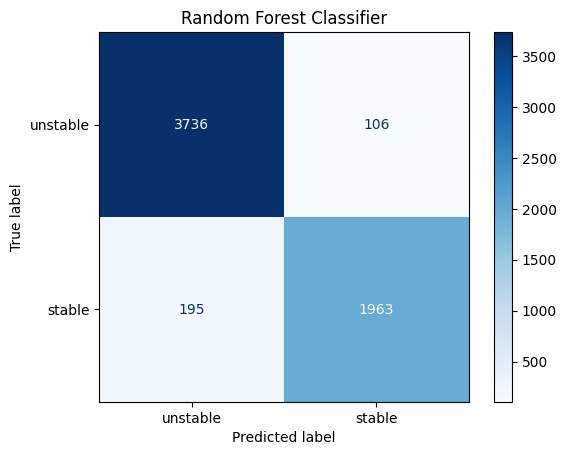

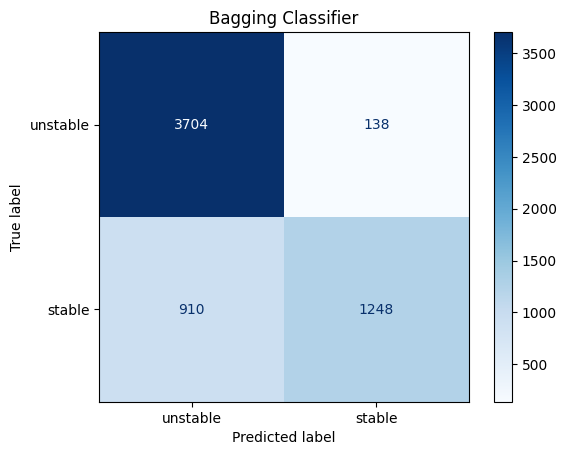

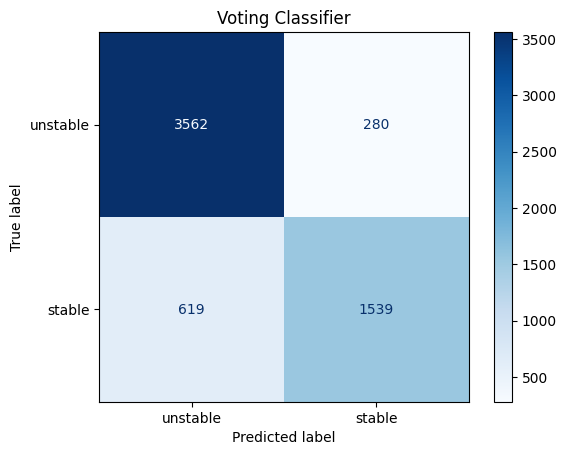

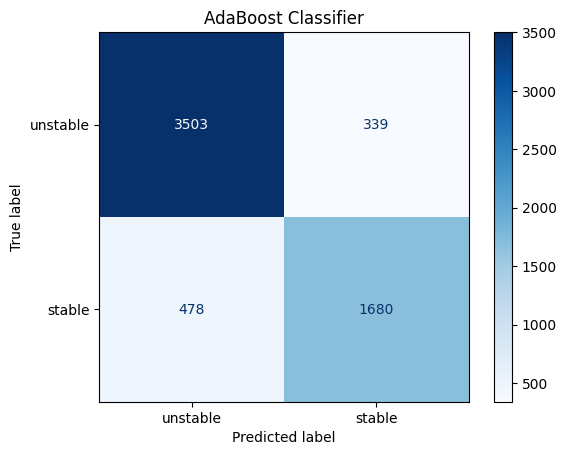

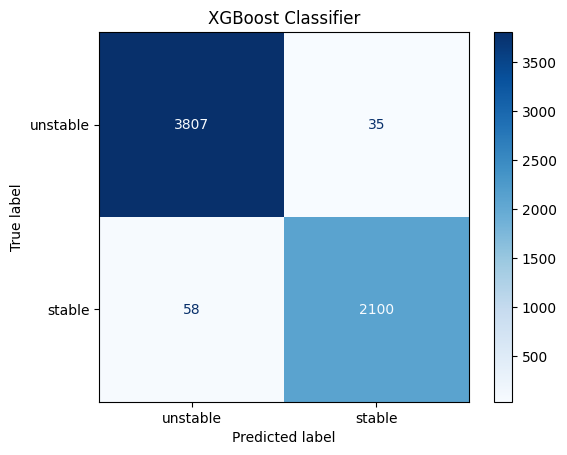

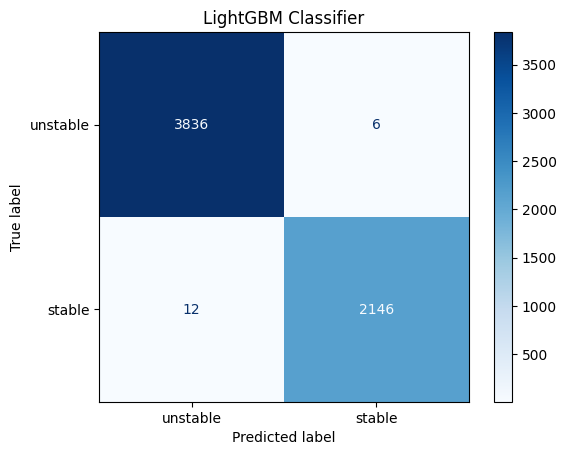

In [12]:
plt.figure()
plt.tight_layout()
for n, cm in enumerate(cms):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['unstable', 'stable'])
    disp.plot(cmap='Blues')
    plt.title(list(models.keys())[n])

# Using correlation matrix

<Axes: >

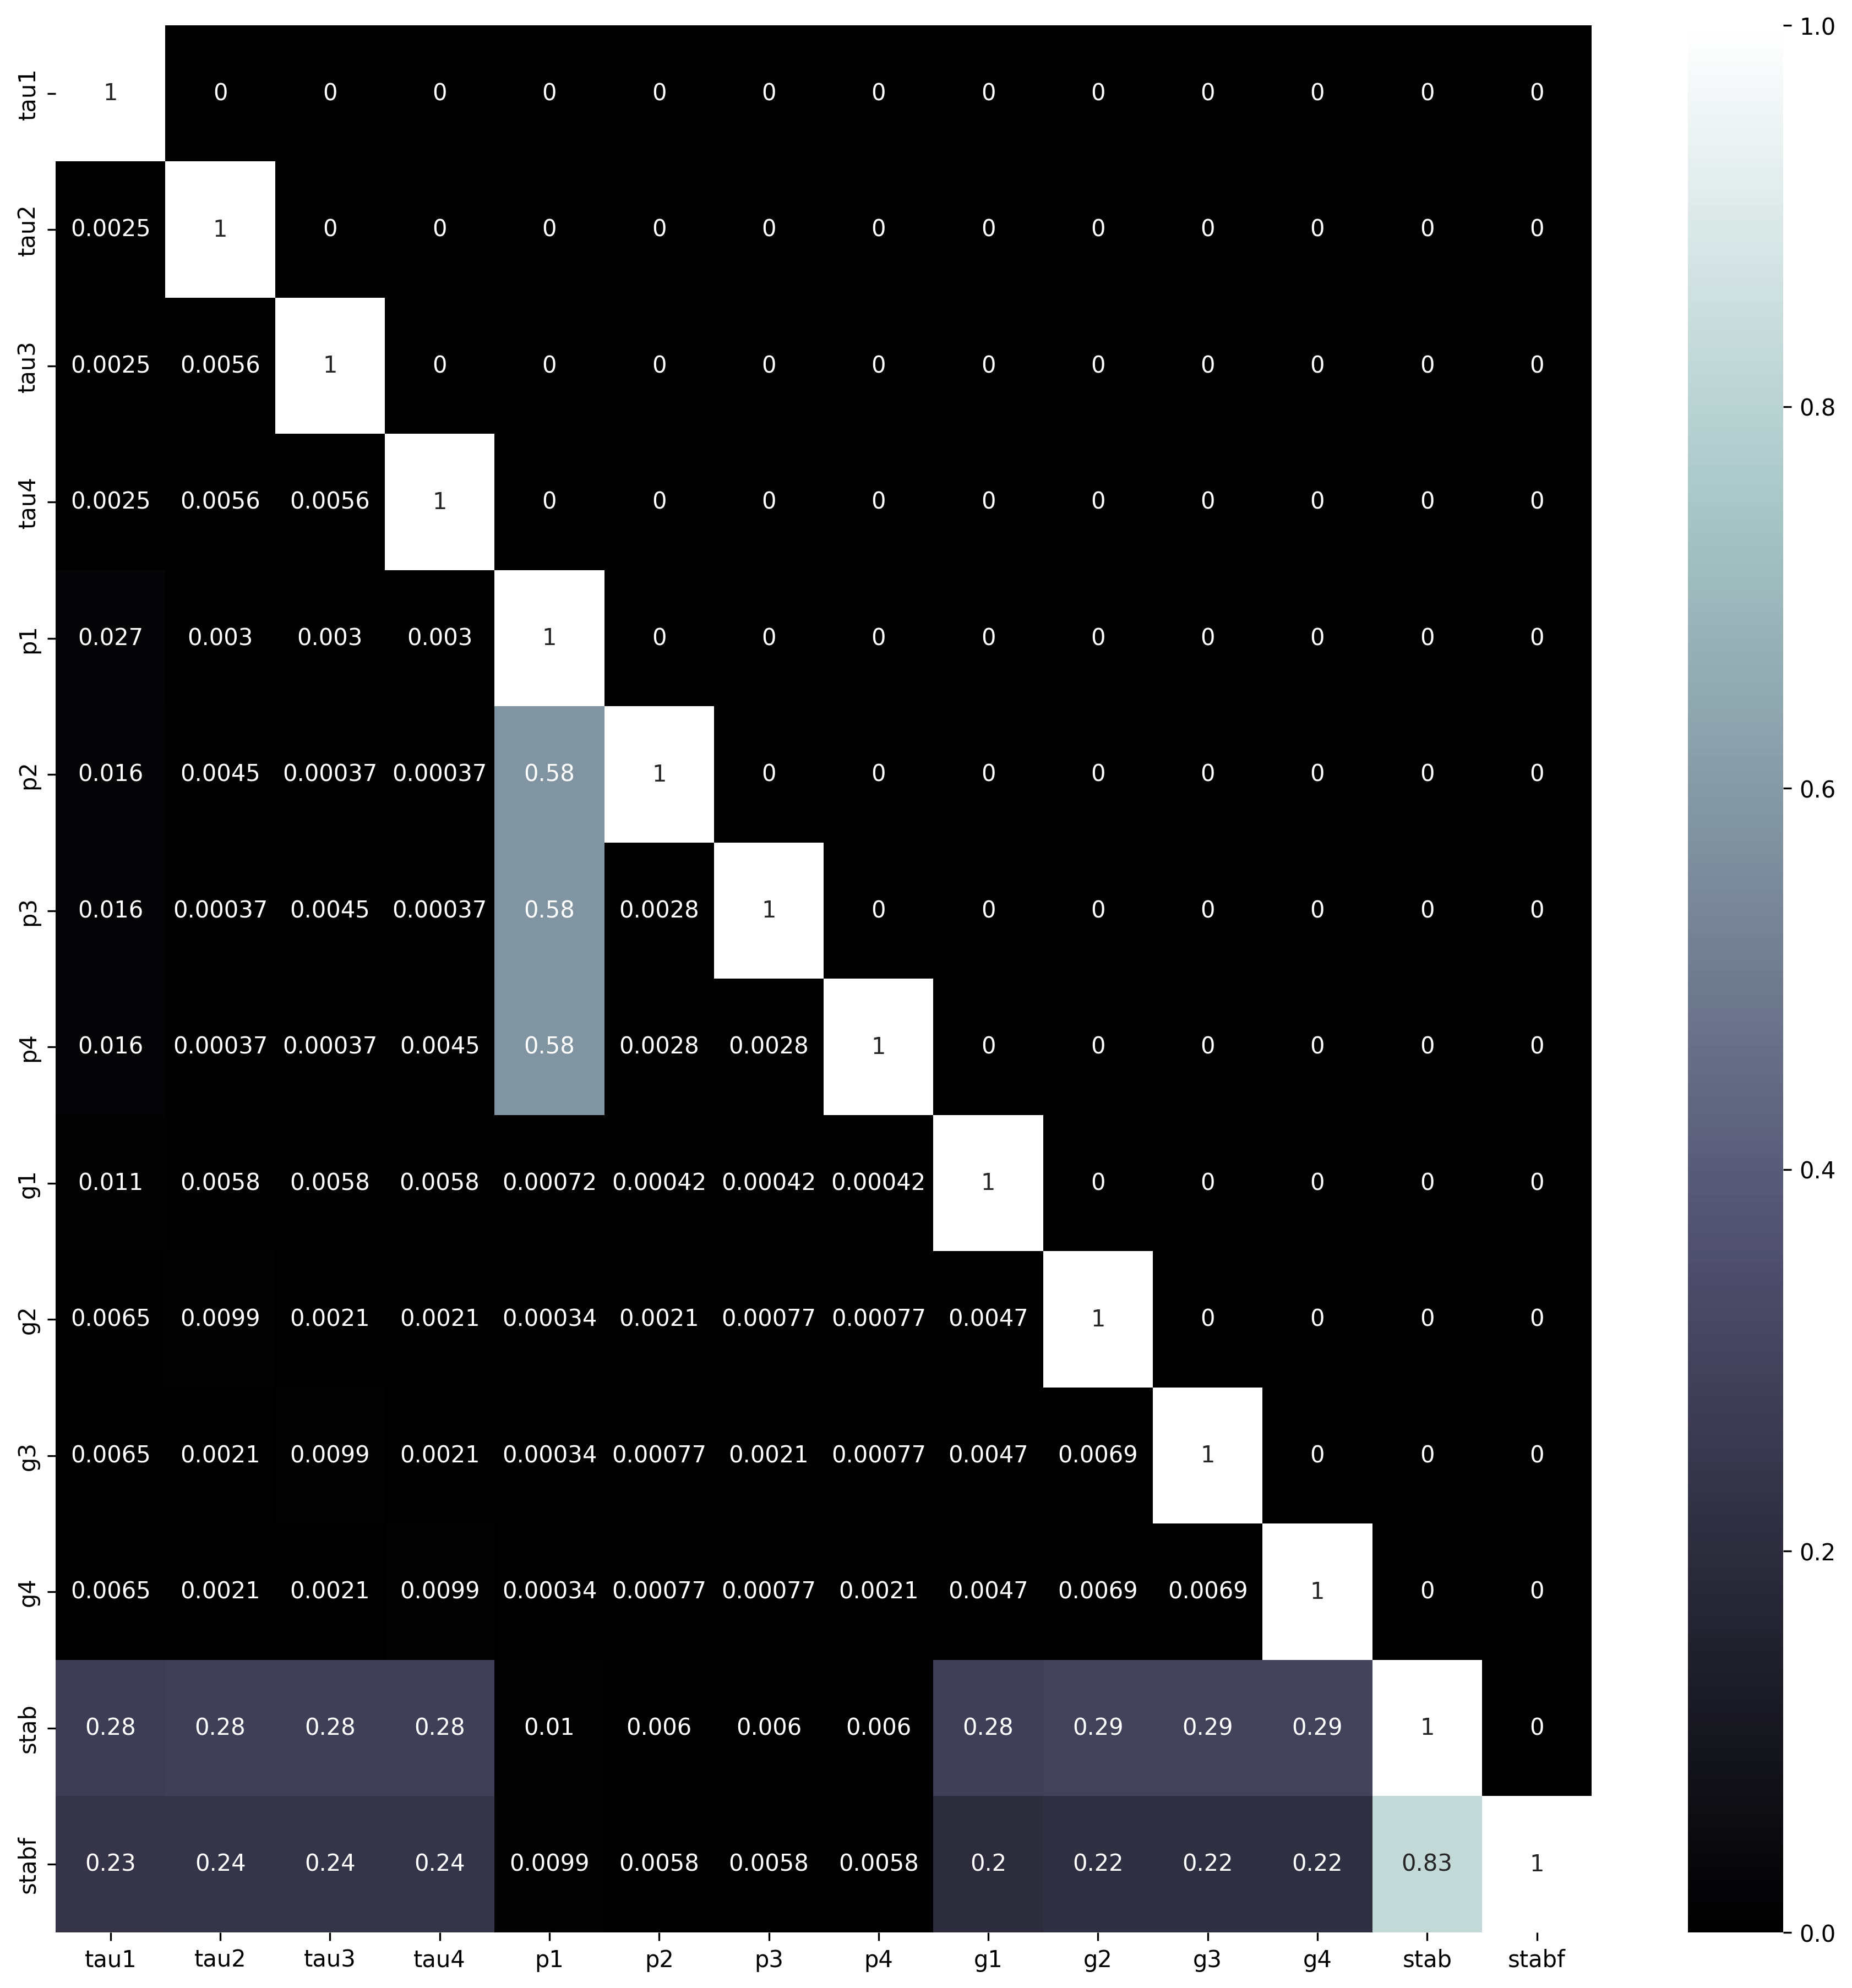

In [13]:
plt.figure(figsize=(15,15), dpi=300)
sns.heatmap(np.tril(np.abs(new_csv.corr())), annot=True, xticklabels=data_csv.columns, yticklabels=data_csv.columns, cmap=plt.cm.bone)

We can see from the matrix that p1-4 has a week correlation to the stabf, so let's try training by dropping these columns and see if there is any improvement

In [14]:
preprocessor = preprocessing.StandardScaler()
trained_models, cms, scores = train_models(models, x_data.drop(['p1', 'p2', 'p3', 'p4'], axis=1), y_data, train_size=0.9, save=False, preprocessor=preprocessor)
model_scores_dict['Correlation Based'] = [f'{s*100:.2f}%' for s in scores[0]]
correlation_training_table = make_scores_table(scores)
correlation_training_table.to_csv('correlation training.csv')

using model: Logistic Regression
Accuracy: 0.8130 ; MAE: 0.1870 ; Precision: 0.7798 ; Recall: 0.6892 ; F1: 0.7317 	 finished in 0.1343 second(s)

using model: Ridge Classifier
Accuracy: 0.8123 ; MAE: 0.1877 ; Precision: 0.7805 ; Recall: 0.6856 ; F1: 0.7300 	 finished in 0.1213 second(s)

using model: SGD classifier
Accuracy: 0.8102 ; MAE: 0.1898 ; Precision: 0.7520 ; Recall: 0.7266 ; F1: 0.7391 	 finished in 0.2253 second(s)

using model: Passive Aggressive Classifier
Accuracy: 0.7432 ; MAE: 0.2568 ; Precision: 0.7110 ; Recall: 0.5153 ; F1: 0.5975 	 finished in 0.1622 second(s)

using model: Linear Discriminant Analysis
Accuracy: 0.8133 ; MAE: 0.1867 ; Precision: 0.7792 ; Recall: 0.6914 ; F1: 0.7327 	 finished in 0.1958 second(s)

using model: Quadratic Discriminant Analysis
Accuracy: 0.8822 ; MAE: 0.1178 ; Precision: 0.8685 ; Recall: 0.8032 ; F1: 0.8345 	 finished in 0.1097 second(s)

using model: Suport Vector Classifier
Accuracy: 0.9863 ; MAE: 0.0137 ; Precision: 0.9841 ; Recall: 0.

From correlation matrix, the results didn't change much by dropping the columns that have weak correlation scores

In [15]:
correlation_training_table

Accuracy       MAE  Precision    Recall  \
Logistic Regression                0.813000  0.187000   0.779817  0.689189   
Ridge Classifier                   0.812333  0.187667   0.780513  0.685586   
SGD classifier                     0.810167  0.189833   0.751981  0.726577   
Passive Aggressive Classifier      0.743167  0.256833   0.711001  0.515315   
Linear Discriminant Analysis       0.813333  0.186667   0.779188  0.691441   
Quadratic Discriminant Analysis    0.882167  0.117833   0.868485  0.803153   
Suport Vector Classifier           0.986333  0.013667   0.984149  0.978829   
Linear Support Vector Classifier   0.813167  0.186833   0.779929  0.689640   
KNeighbors Classifier              0.937833  0.062167   0.951148  0.877027   
Gaussian Naive Bayes               0.831167  0.168833   0.848240  0.662162   
Decision Tree Classifier           0.908000  0.092000   0.876354  0.874775   
Hist Gradient Boosting Classifier  0.959833  0.040167   0.960876  0.929279   
Gradient Boosting Classifier       0.927000  0.073000   0.946393  0.850901   
Random Forest Classifier           0.954333  0.045667   0.955951  0.918919   
Bagging Classifier                 0.841000  0.159000   0.915900  0.627928   
Voting Classifier                  0.843000  0.157000   0.851485  0.697297   
AdaBoost Classifier                0.858000  0.142000   0.834311  0.768919   
XGBoost Classifier                 0.987333  0.012667   0.989051  0.976577   
LightGBM Classifier                0.994667  0.005333   0.994128  0.991441   

                                         F1  
Logistic Regression                0.731707  
Ridge Classifier                   0.729976  
SGD classifier                     0.739061  
Passive Aggressive Classifier      0.597545  
Linear Discriminant Analysis       0.732697  
Quadratic Discriminant Analysis    0.834542  
Suport Vector Classifier           0.981481  
Linear Support Vector Classifier   0.732011  
KNeighbors Classifier              0.912585  
Gaussian Naive Bayes               0.743739  
Decision Tree Classifier           0.875564  
Hist Gradient Boosting Classifier  0.944813  
Gradient Boosting Classifier       0.896110  
Random Forest Classifier           0.937069  
Bagging Classifier                 0.745056  
Voting Classifier                  0.766716  
AdaBoost Classifier                0.800281  
XGBoost Classifier                 0.982774  
LightGBM Classifier                0.992783

# K means clustering

In [16]:
kmeans = KMeans(n_clusters=2, n_init="auto").fit(standard_x)

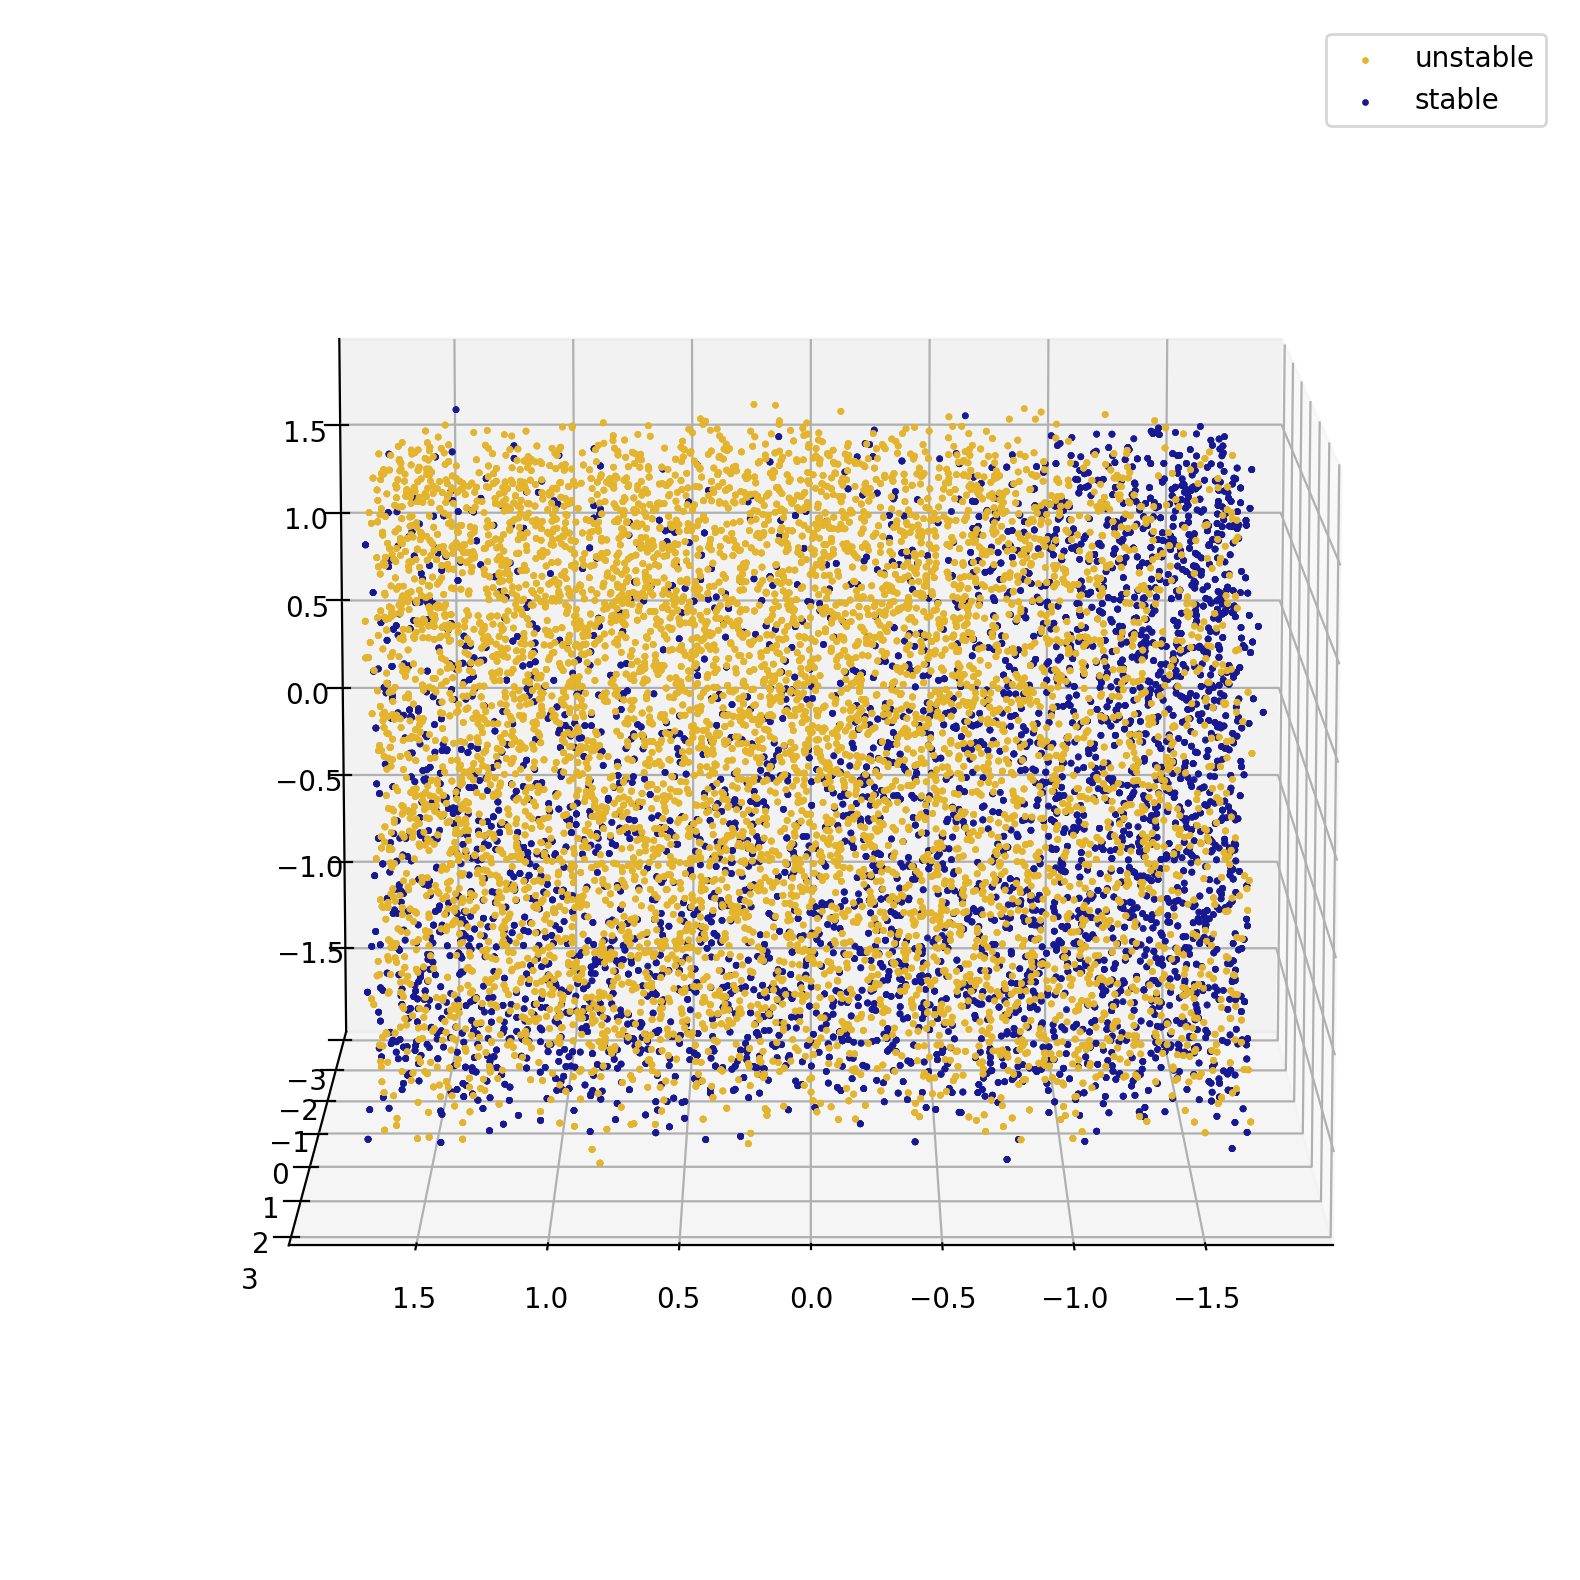

In [17]:
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = plt.subplot(projection='3d')
ax.scatter3D(standard_x.loc[y_data==0]['tau1'], standard_x.loc[y_data==0]['p1'], standard_x.loc[y_data==0]['g1'], s=2, c='#E3B42C', label='unstable')
ax.scatter3D(standard_x.loc[y_data==1]['tau1'], standard_x.loc[y_data==1]['p1'], standard_x.loc[y_data==1]['g1'], s=2, c='#171993', label='stable')
ax.legend()
ax.view_init(10, 90)

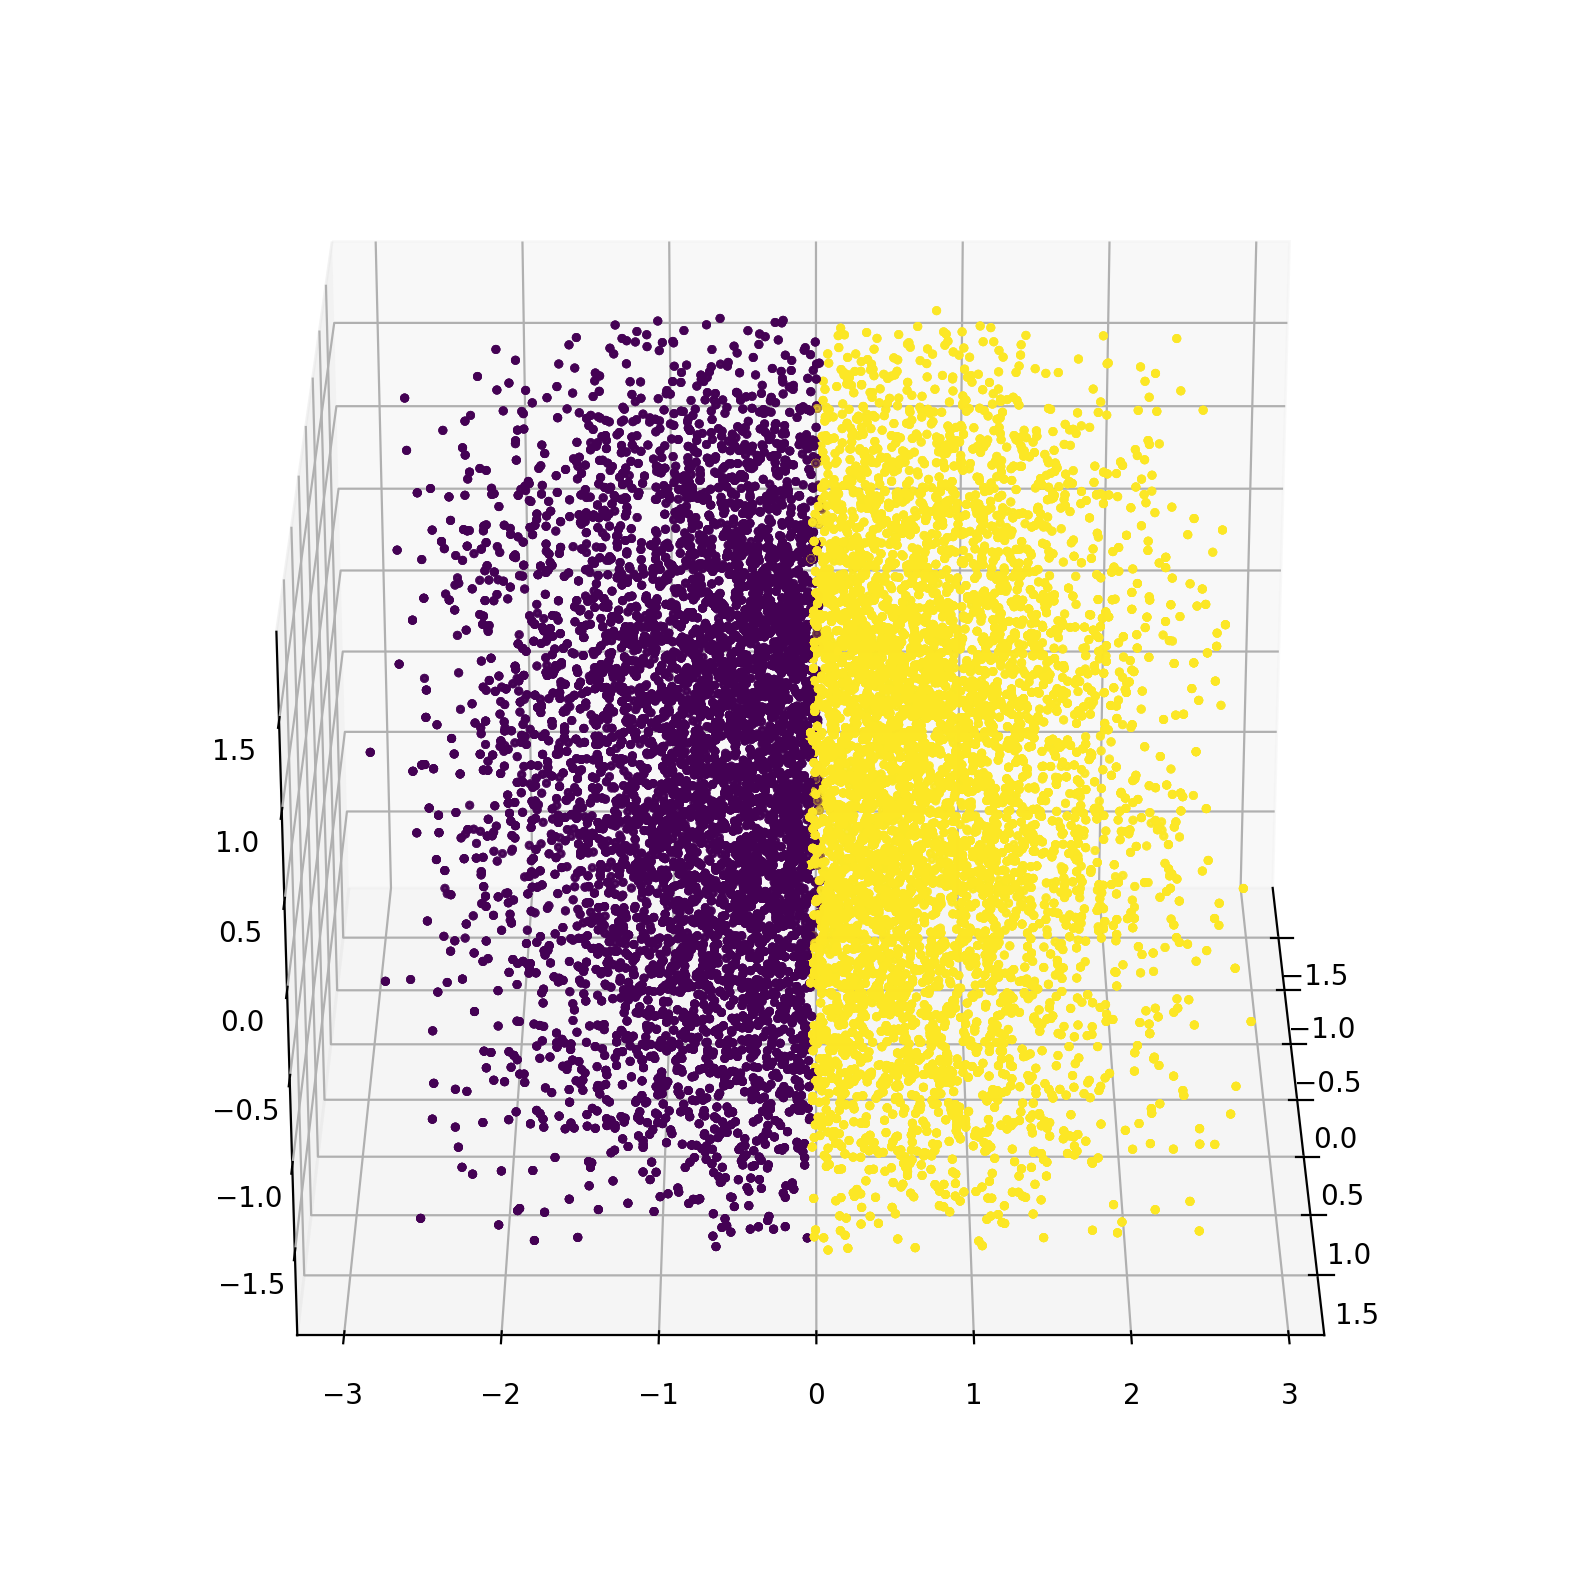

In [18]:
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = plt.subplot(projection='3d')
ax.scatter3D(standard_x['tau1'], standard_x['p1'], standard_x['g1'], s=5, c=kmeans.labels_)
ax.view_init(25, 0)

In [19]:
preprocessor = preprocessing.StandardScaler()
trained_models, cms, scores = train_models(models, x_data.join(pd.Series(kmeans.labels_, name='Clusters')),
                                                 y_data, train_size=0.9, save=False, preprocessor=preprocessor)
model_scores_dict['Kmeans Clustering Based'] = [f'{s*100:.2f}%' for s in scores[0]]
kmeans_training_table = make_scores_table(scores)
kmeans_training_table.to_csv('kmeans training.csv')

using model: Logistic Regression
Accuracy: 0.8187 ; MAE: 0.1813 ; Precision: 0.7789 ; Recall: 0.6963 ; F1: 0.7353 	 finished in 0.1331 second(s)

using model: Ridge Classifier
Accuracy: 0.8192 ; MAE: 0.1808 ; Precision: 0.7809 ; Recall: 0.6949 ; F1: 0.7354 	 finished in 0.1281 second(s)

using model: SGD classifier
Accuracy: 0.8145 ; MAE: 0.1855 ; Precision: 0.7804 ; Recall: 0.6779 ; F1: 0.7255 	 finished in 0.2653 second(s)

using model: Passive Aggressive Classifier
Accuracy: 0.7920 ; MAE: 0.2080 ; Precision: 0.7978 ; Recall: 0.5691 ; F1: 0.6643 	 finished in 0.2074 second(s)

using model: Linear Discriminant Analysis
Accuracy: 0.8187 ; MAE: 0.1813 ; Precision: 0.7777 ; Recall: 0.6982 ; F1: 0.7358 	 finished in 0.1812 second(s)

using model: Quadratic Discriminant Analysis


/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.8772 ; MAE: 0.1228 ; Precision: 0.8595 ; Recall: 0.7894 ; F1: 0.8230 	 finished in 0.1325 second(s)

using model: Suport Vector Classifier
Accuracy: 0.9790 ; MAE: 0.0210 ; Precision: 0.9789 ; Recall: 0.9627 ; F1: 0.9707 	 finished in 34.0403 second(s)

using model: Linear Support Vector Classifier
Accuracy: 0.8192 ; MAE: 0.1808 ; Precision: 0.7792 ; Recall: 0.6977 ; F1: 0.7362 	 finished in 3.2516 second(s)

using model: KNeighbors Classifier
Accuracy: 0.8988 ; MAE: 0.1012 ; Precision: 0.9250 ; Recall: 0.7839 ; F1: 0.8486 	 finished in 6.8772 second(s)

using model: Gaussian Naive Bayes
Accuracy: 0.8335 ; MAE: 0.1665 ; Precision: 0.8434 ; Recall: 0.6627 ; F1: 0.7422 	 finished in 0.0588 second(s)

using model: Decision Tree Classifier
Accuracy: 0.8950 ; MAE: 0.1050 ; Precision: 0.8591 ; Recall: 0.8488 ; F1: 0.8540 	 finished in 1.0384 second(s)

using model: Hist Gradient Boosting Classifier
Accuracy: 0.9625 ; MAE: 0.0375 ; Precision: 0.9651 ; Recall: 0.9300 ; F1: 0.9472 	 

In [20]:
kmeans_training_table

Accuracy       MAE  Precision    Recall  \
Logistic Regression                0.818667  0.181333   0.778866  0.696313   
Ridge Classifier                   0.819167  0.180833   0.780943  0.694931   
SGD classifier                     0.814500  0.185500   0.780371  0.677880   
Passive Aggressive Classifier      0.792000  0.208000   0.797804  0.569124   
Linear Discriminant Analysis       0.818667  0.181333   0.777721  0.698157   
Quadratic Discriminant Analysis    0.877167  0.122833   0.859508  0.789401   
Suport Vector Classifier           0.979000  0.021000   0.978913  0.962673   
Linear Support Vector Classifier   0.819167  0.180833   0.779207  0.697696   
KNeighbors Classifier              0.898833  0.101167   0.924959  0.783871   
Gaussian Naive Bayes               0.833500  0.166500   0.843402  0.662673   
Decision Tree Classifier           0.895000  0.105000   0.859142  0.848848   
Hist Gradient Boosting Classifier  0.962500  0.037500   0.965088  0.929954   
Gradient Boosting Classifier       0.934833  0.065167   0.949016  0.866359   
Random Forest Classifier           0.951333  0.048667   0.954942  0.908295   
Bagging Classifier                 0.848500  0.151500   0.918937  0.637327   
Voting Classifier                  0.846667  0.153333   0.848772  0.700922   
AdaBoost Classifier                0.857167  0.142833   0.832405  0.757604   
XGBoost Classifier                 0.984333  0.015667   0.984142  0.972350   
LightGBM Classifier                0.996833  0.003167   0.996308  0.994931   

                                         F1  
Logistic Regression                0.735280  
Ridge Classifier                   0.735430  
SGD classifier                     0.725524  
Passive Aggressive Classifier      0.664336  
Linear Discriminant Analysis       0.735794  
Quadratic Discriminant Analysis    0.822964  
Suport Vector Classifier           0.970725  
Linear Support Vector Classifier   0.736202  
KNeighbors Classifier              0.848591  
Gaussian Naive Bayes               0.742194  
Decision Tree Classifier           0.853964  
Hist Gradient Boosting Classifier  0.947195  
Gradient Boosting Classifier       0.905806  
Random Forest Classifier           0.931034  
Bagging Classifier                 0.752653  
Voting Classifier                  0.767794  
AdaBoost Classifier                0.793245  
XGBoost Classifier                 0.978210  
LightGBM Classifier                0.995619

# Mutual Information Regression

In [21]:
mi_scores = make_mi_scores(x_data, y_data)
mi_scores

p1      0.655435
tau1    0.654377
g1      0.652775
tau4    0.256578
tau2    0.256578
tau3    0.256578
g2      0.248290
g3      0.248290
g4      0.248290
p2      0.236279
p3      0.236279
p4      0.236279
Name: MI Scores, dtype: float64

We notice that columns tau1, g1, p1 have a strong mi score with the output, so let's train only on these columns and see if there is any change

In [22]:
best_mi_cols = list(mi_scores.index[:3])
x_data[best_mi_cols]

p1      tau1        g1
0      3.763085  2.959060  0.650456
1      5.067812  9.304097  0.413441
2      3.405158  8.971707  0.163041
3      3.963791  0.716415  0.446209
4      3.525811  3.134112  0.797110
...         ...       ...       ...
59995  3.343416  2.930406  0.601709
59996  4.349512  3.392299  0.502079
59997  4.299976  2.364034  0.487838
59998  2.514755  9.631511  0.365246
59999  3.492807  6.530527  0.073056

[60000 rows x 3 columns]

In [23]:
preprocessor = preprocessing.StandardScaler()
trained_models, cms, scores = train_models(models, x_data[best_mi_cols], y_data, train_size=0.9, save=False, preprocessor=preprocessor)
model_scores_dict['Mutual Information Regression Based'] = [f'{s*100:.2f}%' for s in scores[0]]
MI_training_table = make_scores_table(scores)
MI_training_table.to_csv('MI training.csv')

using model: Logistic Regression
Accuracy: 0.6568 ; MAE: 0.3432 ; Precision: 0.5452 ; Recall: 0.2899 ; F1: 0.3785 	 finished in 0.0950 second(s)

using model: Ridge Classifier
Accuracy: 0.6573 ; MAE: 0.3427 ; Precision: 0.5486 ; Recall: 0.2792 ; F1: 0.3701 	 finished in 0.0955 second(s)

using model: SGD classifier


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6395 ; MAE: 0.3605 ; Precision: 0.0000 ; Recall: 0.0000 ; F1: 0.0000 	 finished in 0.2211 second(s)

using model: Passive Aggressive Classifier
Accuracy: 0.6440 ; MAE: 0.3560 ; Precision: 0.5049 ; Recall: 0.6375 ; F1: 0.5635 	 finished in 0.1405 second(s)

using model: Linear Discriminant Analysis
Accuracy: 0.6563 ; MAE: 0.3437 ; Precision: 0.5429 ; Recall: 0.2954 ; F1: 0.3826 	 finished in 0.1183 second(s)

using model: Quadratic Discriminant Analysis
Accuracy: 0.6900 ; MAE: 0.3100 ; Precision: 0.6135 ; Recall: 0.3786 ; F1: 0.4683 	 finished in 0.0833 second(s)

using model: Suport Vector Classifier
Accuracy: 0.6922 ; MAE: 0.3078 ; Precision: 0.6312 ; Recall: 0.3514 ; F1: 0.4514 	 finished in 117.4762 second(s)

using model: Linear Support Vector Classifier
Accuracy: 0.6573 ; MAE: 0.3427 ; Precision: 0.5486 ; Recall: 0.2792 ; F1: 0.3701 	 finished in 1.1202 second(s)

using model: KNeighbors Classifier
Accuracy: 0.7000 ; MAE: 0.3000 ; Precision: 0.5913 ; Recall: 0.5432 ; F

We notice that a lot of models' performances reduced. However, we also see that some models achieved 100% accuracy with 0 mean abosulte error

In [24]:
MI_training_table

Accuracy       MAE  Precision    Recall  \
Logistic Regression                0.656833  0.343167   0.545217  0.289875   
Ridge Classifier                   0.657333  0.342667   0.548592  0.279242   
SGD classifier                     0.639500  0.360500   0.000000  0.000000   
Passive Aggressive Classifier      0.644000  0.356000   0.504943  0.637540   
Linear Discriminant Analysis       0.656333  0.343667   0.542906  0.295423   
Quadratic Discriminant Analysis    0.690000  0.310000   0.613483  0.378641   
Suport Vector Classifier           0.692167  0.307833   0.631229  0.351364   
Linear Support Vector Classifier   0.657333  0.342667   0.548592  0.279242   
KNeighbors Classifier              0.700000  0.300000   0.591344  0.543227   
Gaussian Naive Bayes               0.668000  0.332000   0.575066  0.302820   
Decision Tree Classifier           1.000000  0.000000   1.000000  1.000000   
Hist Gradient Boosting Classifier  0.757167  0.242833   0.732543  0.514101   
Gradient Boosting Classifier       0.707167  0.292833   0.642958  0.422099   
Random Forest Classifier           1.000000  0.000000   1.000000  1.000000   
Bagging Classifier                 0.936833  0.063167   0.973461  0.847896   
Voting Classifier                  0.679833  0.320167   0.602716  0.328248   
AdaBoost Classifier                0.681833  0.318167   0.608177  0.330097   
XGBoost Classifier                 0.999500  0.000500   1.000000  0.998613   
LightGBM Classifier                0.971667  0.028333   0.988241  0.932501   

                                         F1  
Logistic Regression                0.378509  
Ridge Classifier                   0.370098  
SGD classifier                     0.000000  
Passive Aggressive Classifier      0.563547  
Linear Discriminant Analysis       0.382635  
Quadratic Discriminant Analysis    0.468268  
Suport Vector Classifier           0.451440  
Linear Support Vector Classifier   0.370098  
KNeighbors Classifier              0.566265  
Gaussian Naive Bayes               0.396729  
Decision Tree Classifier           1.000000  
Hist Gradient Boosting Classifier  0.604184  
Gradient Boosting Classifier       0.509629  
Random Forest Classifier           1.000000  
Bagging Classifier                 0.906350  
Voting Classifier                  0.425022  
AdaBoost Classifier                0.427929  
XGBoost Classifier                 0.999306  
LightGBM Classifier                0.959562

# Principal Component Analysis (PCA)

In [25]:
pca = PCA(n_components=3)

x_pca = pca.fit_transform(standard_x)
pca_index = [f'PC{i+1}' for i in range(x_pca.shape[1])]
x_pca = pd.DataFrame(x_pca, columns=pca_index)

x_pca

PC1       PC2       PC3
0     -0.004904  1.138208 -1.624617
1     -2.527426 -1.248905 -0.705855
2      0.602400 -0.221604 -0.134095
3     -0.338799  0.650442  0.313589
4      0.438793  0.904773 -1.073020
...         ...       ...       ...
59995  0.791641  0.627182 -0.650330
59996 -1.093968 -0.514009  1.310824
59997 -0.988838 -0.098475  1.310948
59998  2.263664 -0.372624 -1.443275
59999  0.461422  1.377818 -0.302466

[60000 rows x 3 columns]

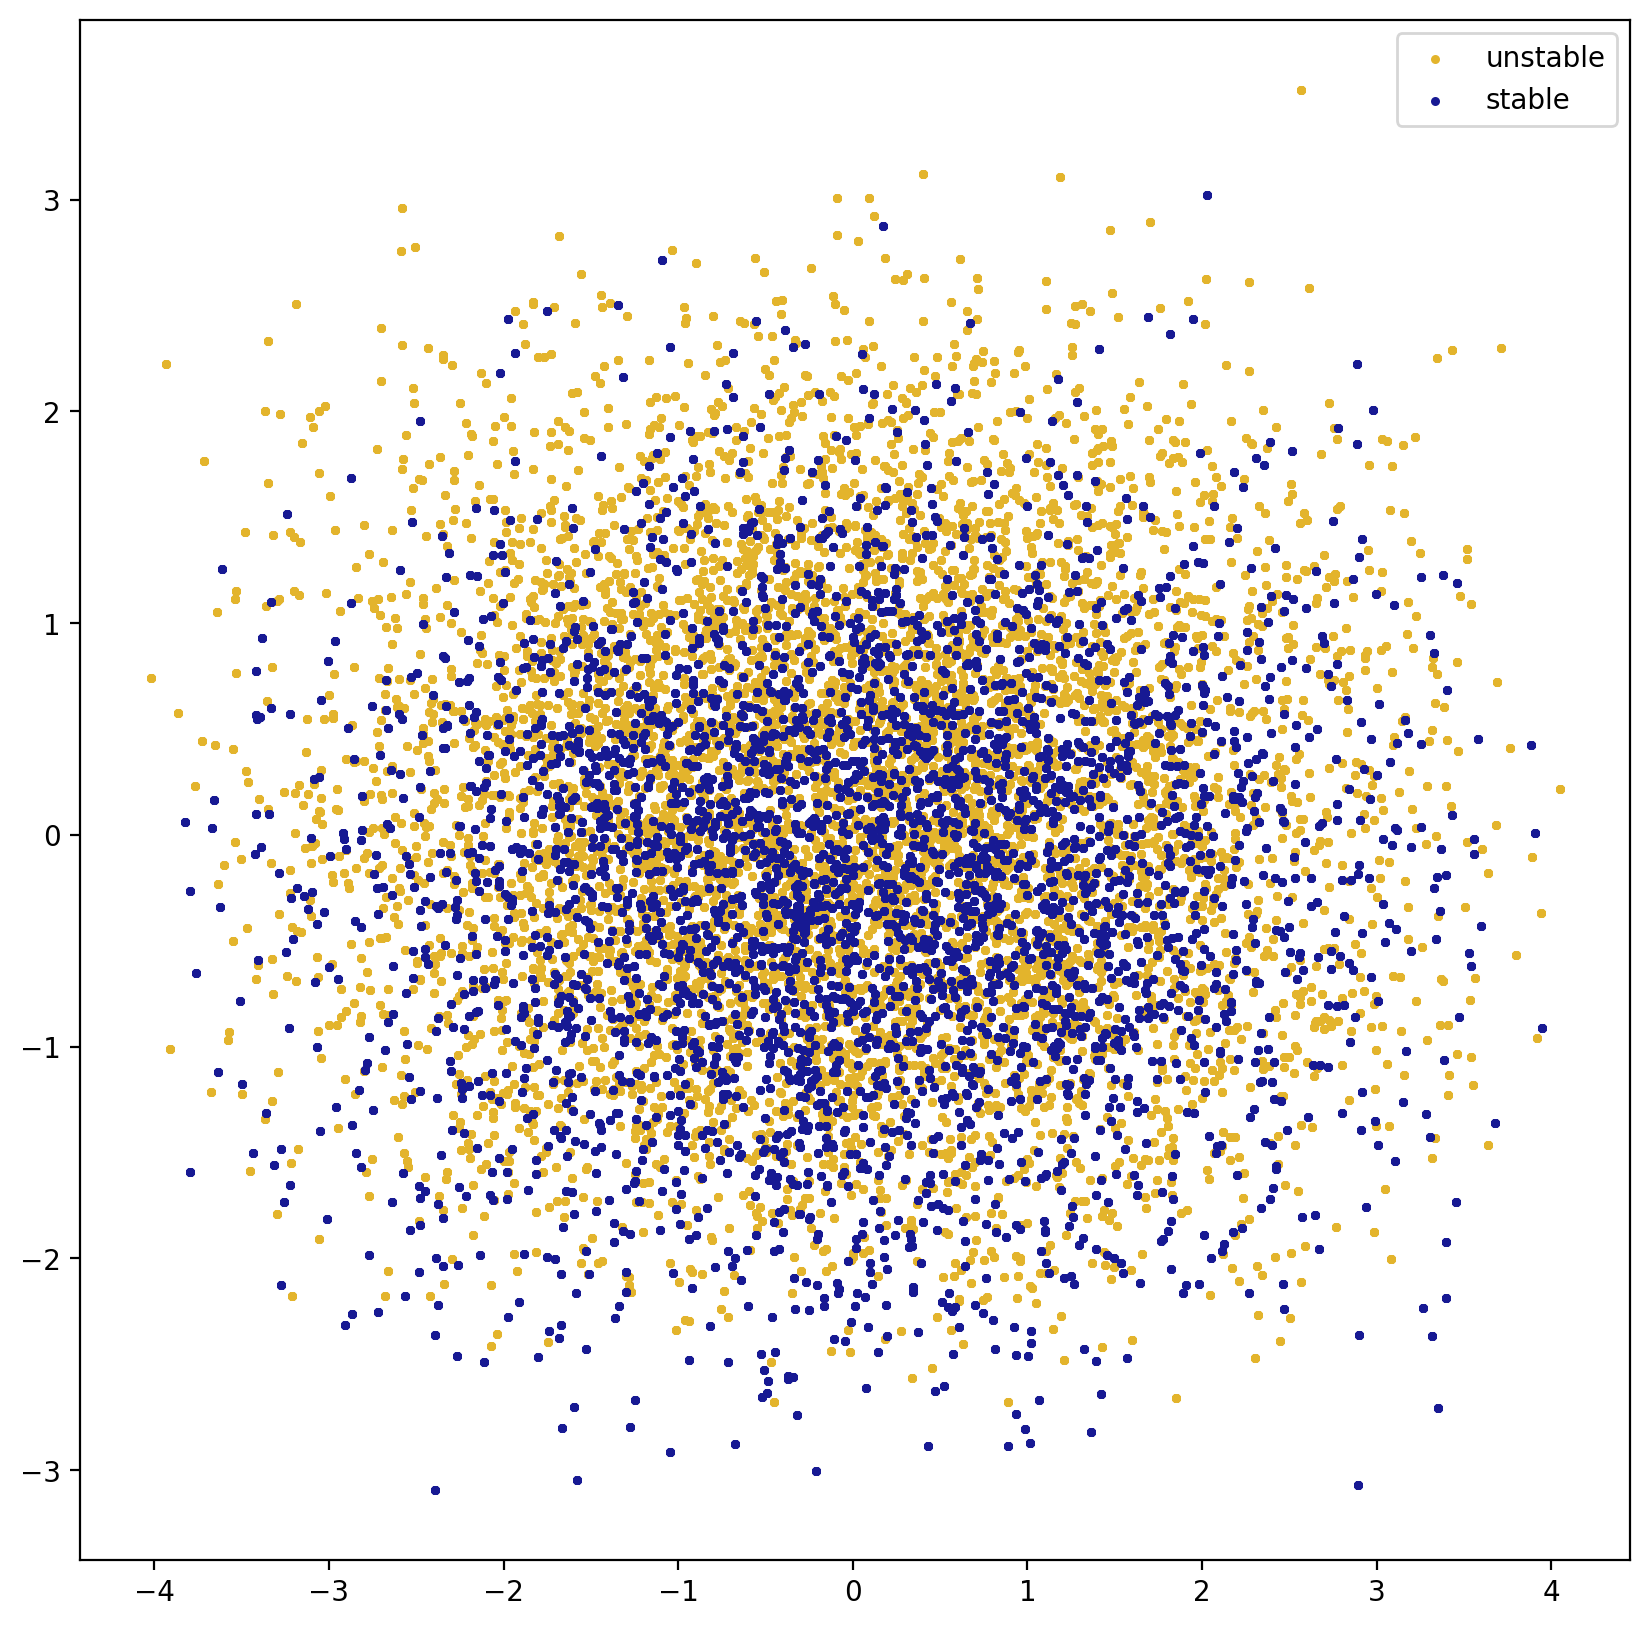

In [26]:
fig = plt.figure(figsize=(10, 10), dpi=200)
plt.scatter(x_pca.loc[y_data==0]['PC1'], x_pca.loc[y_data==0]['PC2'], s=5, c='#E3B42C', label='unstable')
plt.scatter(x_pca.loc[y_data==1]['PC1'], x_pca.loc[y_data==1]['PC2'], s=5, c='#171993', label='stable')
plt.legend()

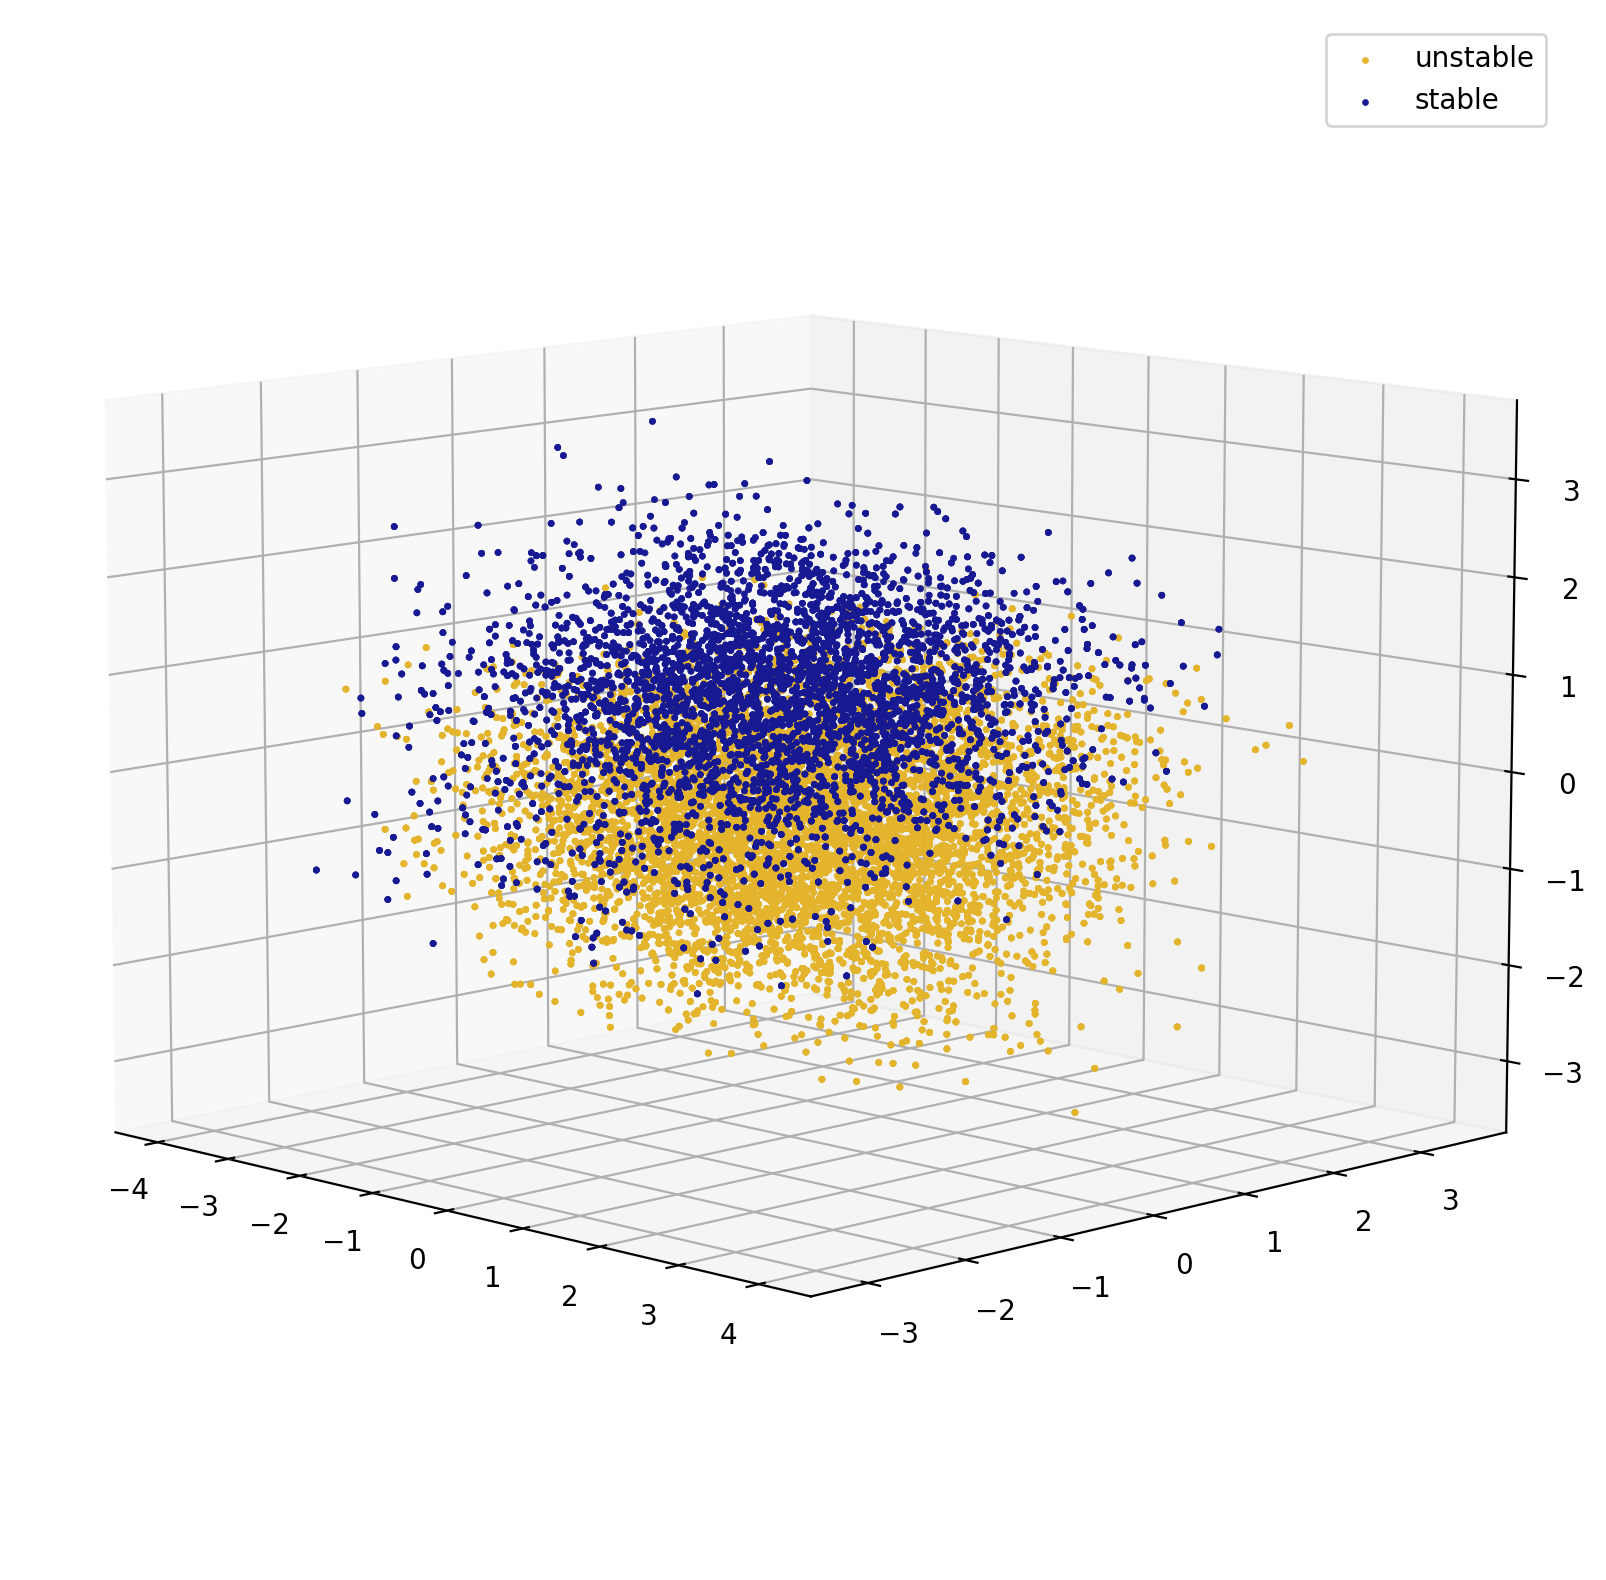

In [27]:
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = plt.subplot(projection='3d')
ax.scatter3D(x_pca.loc[y_data==0]['PC1'], x_pca.loc[y_data==0]['PC2'], x_pca.loc[y_data==0]['PC3'], s=2, c='#E3B42C', label='unstable')
ax.scatter3D(x_pca.loc[y_data==1]['PC1'], x_pca.loc[y_data==1]['PC2'], x_pca.loc[y_data==1]['PC3'], s=2, c='#171993', label='stable')
ax.legend()
ax.view_init(10, -45)

From PCA, the 2d projection doesn't tell us much, it's noisy and the labels are scattered. The 3d projection however we can see a clearer distinction between the labels. Now let's try training the models on PCA

In [28]:
preprocessor = preprocessing.StandardScaler()
trained_models, cms, scores = train_models(models, x_pca, y_data, train_size=0.9, save=True, preprocessor=preprocessor)
model_scores_dict['PCA based'] = [f'{s*100:.2f}%' for s in scores[0]]
PCA_training_table = make_scores_table(scores)
PCA_training_table.to_csv('PCA training.csv')

using model: Logistic Regression
Accuracy: 0.8175 ; MAE: 0.1825 ; Precision: 0.7664 ; Recall: 0.7153 ; F1: 0.7400 	 finished in 0.1207 second(s)

using model: Ridge Classifier
Accuracy: 0.8175 ; MAE: 0.1825 ; Precision: 0.7690 ; Recall: 0.7107 ; F1: 0.7387 	 finished in 0.1036 second(s)

using model: SGD classifier
Accuracy: 0.8168 ; MAE: 0.1832 ; Precision: 0.7740 ; Recall: 0.6997 ; F1: 0.7350 	 finished in 0.1724 second(s)

using model: Passive Aggressive Classifier
Accuracy: 0.7550 ; MAE: 0.2450 ; Precision: 0.6505 ; Recall: 0.7025 ; F1: 0.6755 	 finished in 0.1460 second(s)

using model: Linear Discriminant Analysis
Accuracy: 0.8170 ; MAE: 0.1830 ; Precision: 0.7642 ; Recall: 0.7172 ; F1: 0.7399 	 finished in 0.1247 second(s)

using model: Quadratic Discriminant Analysis
Accuracy: 0.8173 ; MAE: 0.1827 ; Precision: 0.7621 ; Recall: 0.7222 ; F1: 0.7416 	 finished in 0.1039 second(s)

using model: Suport Vector Classifier
Accuracy: 0.8240 ; MAE: 0.1760 ; Precision: 0.8046 ; Recall: 0.

<Figure size 640x480 with 0 Axes>

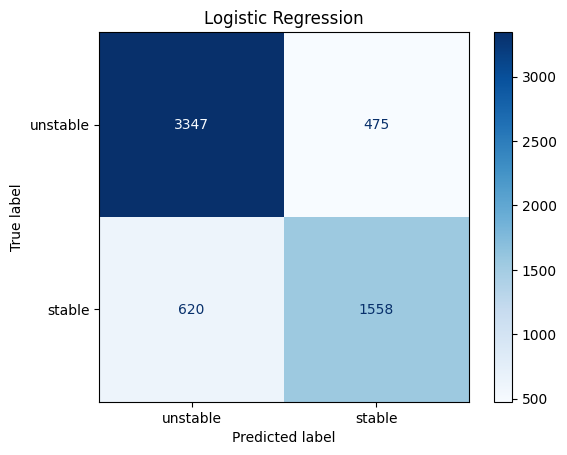

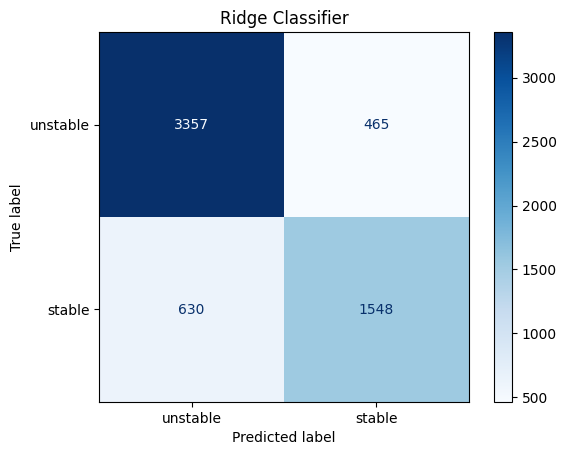

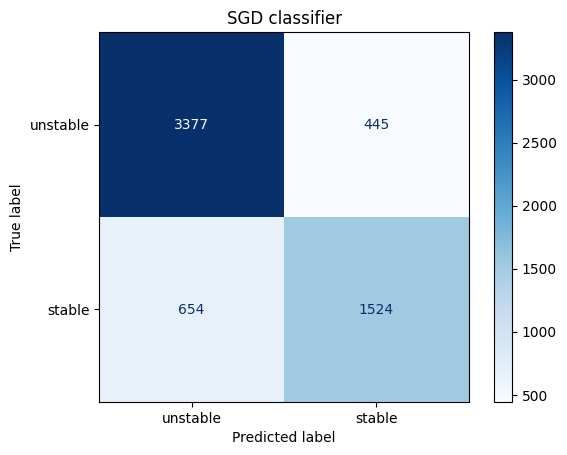

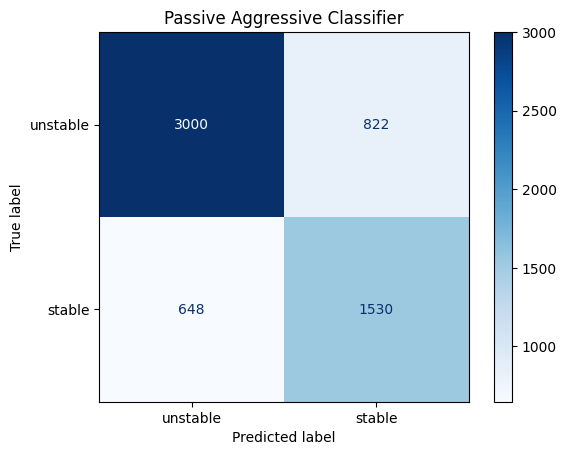

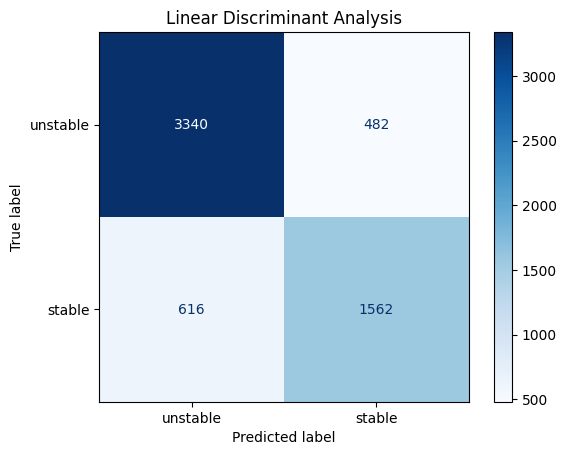

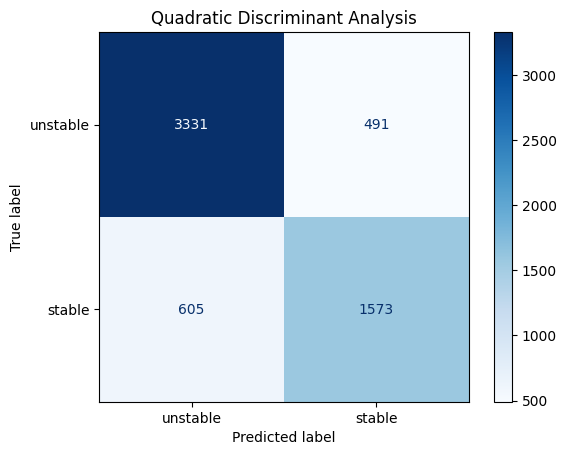

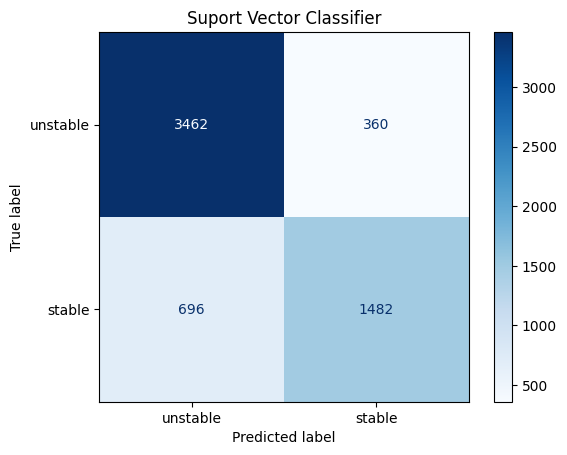

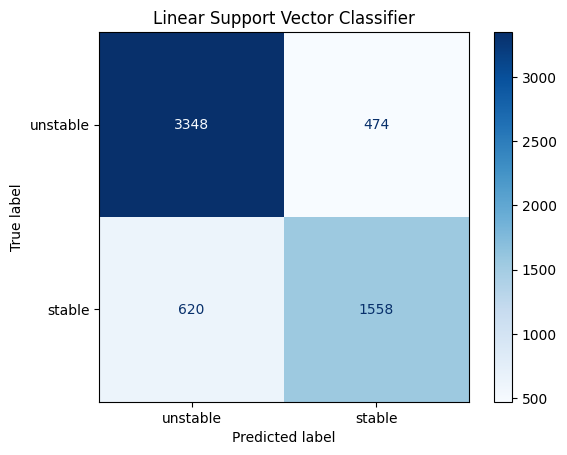

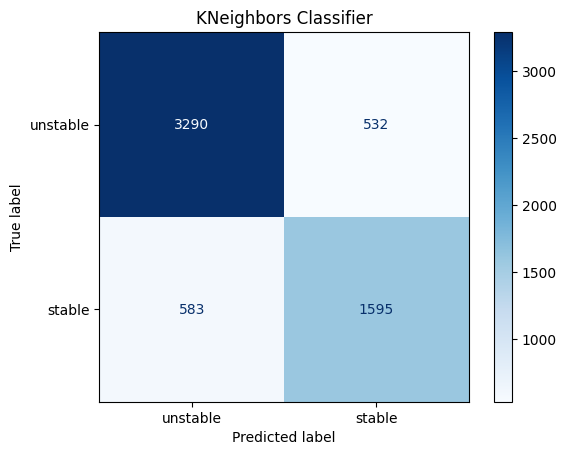

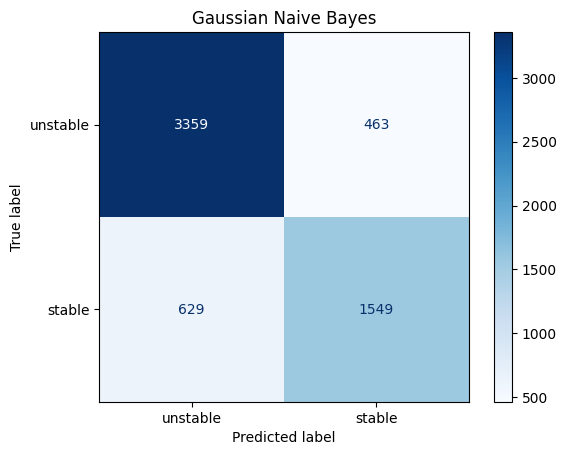

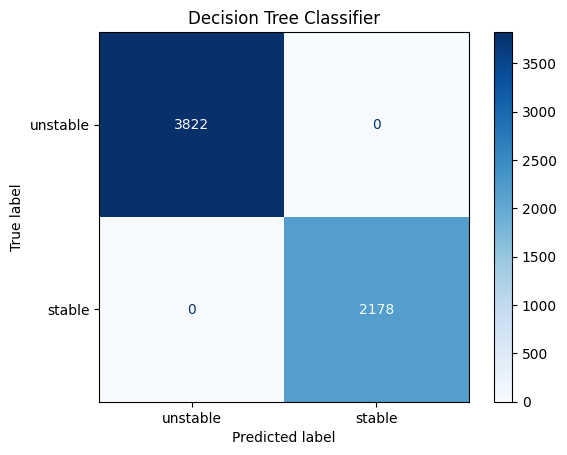

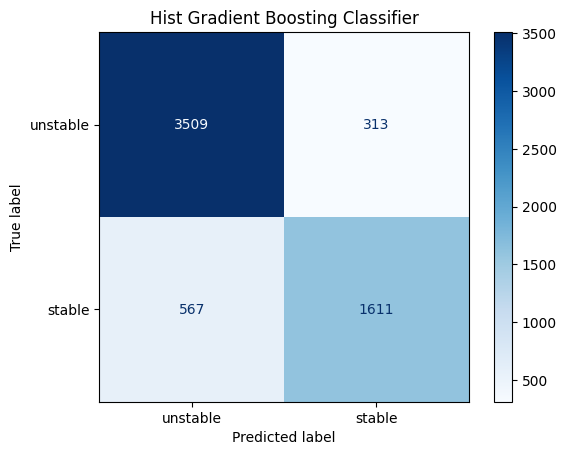

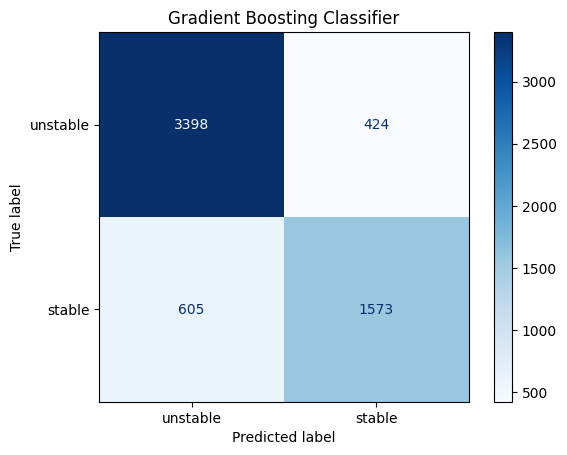

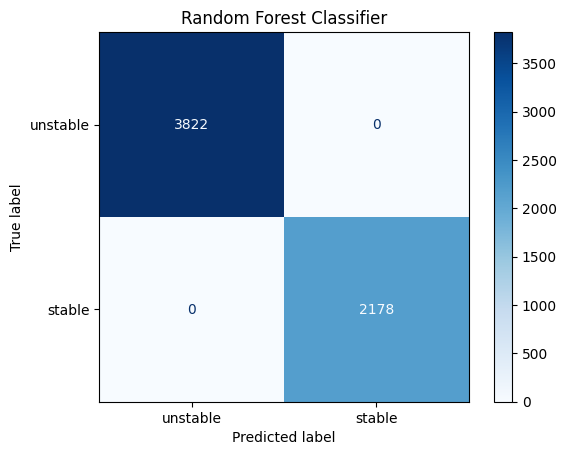

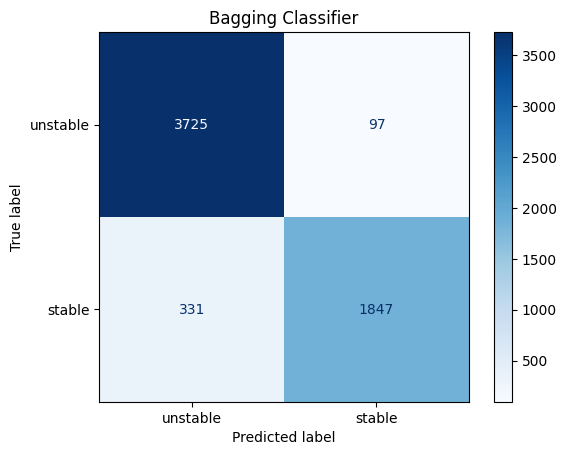

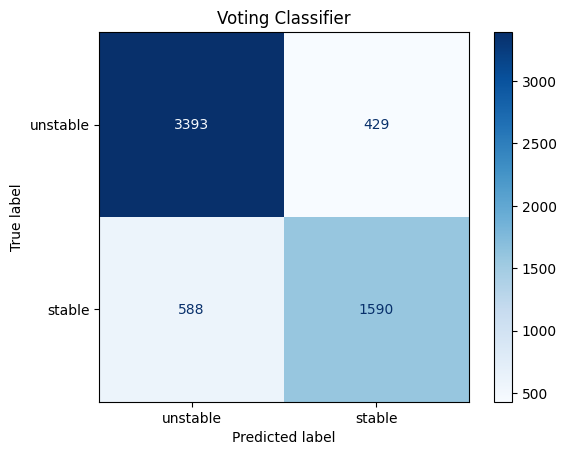

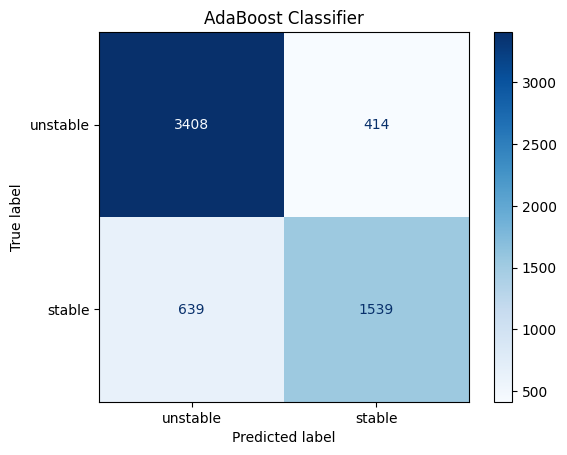

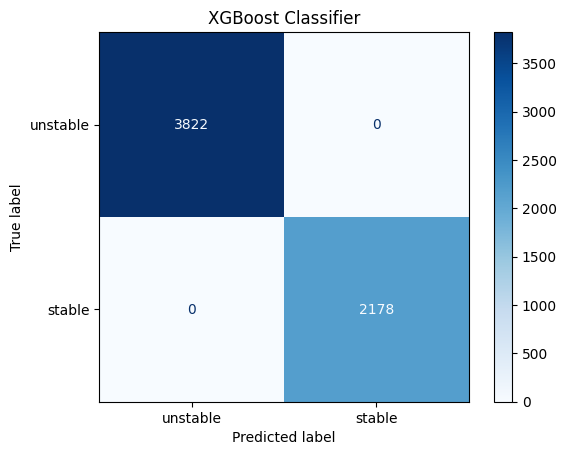

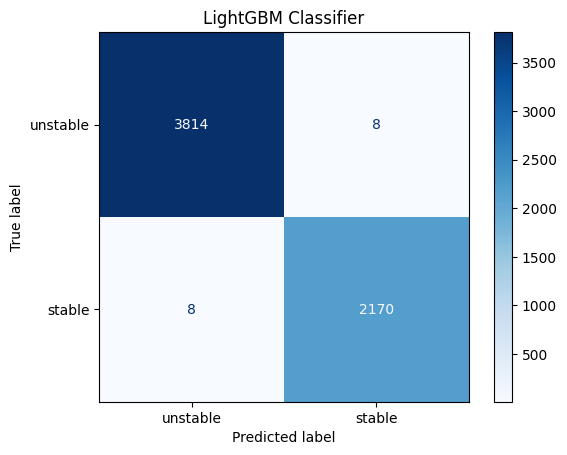

In [29]:
plt.figure()
plt.tight_layout()
for n, cm in enumerate(cms):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['unstable', 'stable'])
    disp.plot(cmap='Blues')
    plt.title(list(models.keys())[n])

Training only on PCA, we noticed that models in general score higher than mutual information, but we also notice some models achieving 100% accuracy with 0 error on the test data

In [30]:
PCA_training_table

Accuracy       MAE  Precision    Recall  \
Logistic Regression                0.817500  0.182500   0.766355  0.715335   
Ridge Classifier                   0.817500  0.182500   0.769001  0.710744   
SGD classifier                     0.816833  0.183167   0.773997  0.699725   
Passive Aggressive Classifier      0.755000  0.245000   0.650510  0.702479   
Linear Discriminant Analysis       0.817000  0.183000   0.764188  0.717172   
Quadratic Discriminant Analysis    0.817333  0.182667   0.762112  0.722222   
Suport Vector Classifier           0.824000  0.176000   0.804560  0.680441   
Linear Support Vector Classifier   0.817667  0.182333   0.766732  0.715335   
KNeighbors Classifier              0.814167  0.185833   0.749882  0.732323   
Gaussian Naive Bayes               0.818000  0.182000   0.769881  0.711203   
Decision Tree Classifier           1.000000  0.000000   1.000000  1.000000   
Hist Gradient Boosting Classifier  0.853333  0.146667   0.837318  0.739669   
Gradient Boosting Classifier       0.828500  0.171500   0.787682  0.722222   
Random Forest Classifier           1.000000  0.000000   1.000000  1.000000   
Bagging Classifier                 0.928667  0.071333   0.950103  0.848026   
Voting Classifier                  0.830500  0.169500   0.787519  0.730028   
AdaBoost Classifier                0.824500  0.175500   0.788018  0.706612   
XGBoost Classifier                 1.000000  0.000000   1.000000  1.000000   
LightGBM Classifier                0.997333  0.002667   0.996327  0.996327   

                                         F1  
Logistic Regression                0.739967  
Ridge Classifier                   0.738726  
SGD classifier                     0.734989  
Passive Aggressive Classifier      0.675497  
Linear Discriminant Analysis       0.739934  
Quadratic Discriminant Analysis    0.741631  
Suport Vector Classifier           0.737313  
Linear Support Vector Classifier   0.740143  
KNeighbors Classifier              0.740999  
Gaussian Naive Bayes               0.739379  
Decision Tree Classifier           1.000000  
Hist Gradient Boosting Classifier  0.785471  
Gradient Boosting Classifier       0.753533  
Random Forest Classifier           1.000000  
Bagging Classifier                 0.896167  
Voting Classifier                  0.757684  
AdaBoost Classifier                0.745098  
XGBoost Classifier                 1.000000  
LightGBM Classifier                0.996327

In [31]:
scores_df = pd.DataFrame(model_scores_dict, index=list(models.keys()))
scores_df.to_csv('Scores.csv')

In [32]:
scores_df

Standard Training Correlation Based  \
Logistic Regression                          82.18%            81.30%   
Ridge Classifier                             82.00%            81.23%   
SGD classifier                               81.92%            81.02%   
Passive Aggressive Classifier                79.43%            74.32%   
Linear Discriminant Analysis                 82.15%            81.33%   
Quadratic Discriminant Analysis              87.62%            88.22%   
Suport Vector Classifier                     98.13%            98.63%   
Linear Support Vector Classifier             82.15%            81.32%   
KNeighbors Classifier                        90.20%            93.78%   
Gaussian Naive Bayes                         83.60%            83.12%   
Decision Tree Classifier                     89.35%            90.80%   
Hist Gradient Boosting Classifier            96.30%            95.98%   
Gradient Boosting Classifier                 93.10%            92.70%   
Random Forest Classifier                     94.98%            95.43%   
Bagging Classifier                           82.53%            84.10%   
Voting Classifier                            85.02%            84.30%   
AdaBoost Classifier                          86.38%            85.80%   
XGBoost Classifier                           98.45%            98.73%   
LightGBM Classifier                          99.70%            99.47%   

                                  Kmeans Clustering Based  \
Logistic Regression                                81.87%   
Ridge Classifier                                   81.92%   
SGD classifier                                     81.45%   
Passive Aggressive Classifier                      79.20%   
Linear Discriminant Analysis                       81.87%   
Quadratic Discriminant Analysis                    87.72%   
Suport Vector Classifier                           97.90%   
Linear Support Vector Classifier                   81.92%   
KNeighbors Classifier                              89.88%   
Gaussian Naive Bayes                               83.35%   
Decision Tree Classifier                           89.50%   
Hist Gradient Boosting Classifier                  96.25%   
Gradient Boosting Classifier                       93.48%   
Random Forest Classifier                           95.13%   
Bagging Classifier                                 84.85%   
Voting Classifier                                  84.67%   
AdaBoost Classifier                                85.72%   
XGBoost Classifier                                 98.43%   
LightGBM Classifier                                99.68%   

                                  Mutual Information Regression Based  \
Logistic Regression                                            65.68%   
Ridge Classifier                                               65.73%   
SGD classifier                                                 63.95%   
Passive Aggressive Classifier                                  64.40%   
Linear Discriminant Analysis                                   65.63%   
Quadratic Discriminant Analysis                                69.00%   
Suport Vector Classifier                                       69.22%   
Linear Support Vector Classifier                               65.73%   
KNeighbors Classifier                                          70.00%   
Gaussian Naive Bayes                                           66.80%   
Decision Tree Classifier                                      100.00%   
Hist Gradient Boosting Classifier                              75.72%   
Gradient Boosting Classifier                                   70.72%   
Random Forest Classifier                                      100.00%   
Bagging Classifier                                             93.68%   
Voting Classifier                                              67.98%   
AdaBoost Classifier                                            68.18%   
XGBoost Classifier                    